# Scenario analysis

## Set up environment

In [1]:
# Constants used throughout the file
SCENARIOS = [
    "BASELINE",
    "SCN_CORE",
    
    "SCN_MIN_LEY",
    "SCN_SNG",
    "SCN_ORG",
]

PROTEIN_CONTENTS = {
    "Peas (add)": 220,
    "Wheat (add)": 67.15,
    "meat": 155.5,
    "milk": 35.0,
}

RENAME_MAP = {
    "Peas (add)": "Peas",
    "Wheat (add)": "Wheat",
    "milk": "Cattle milk",
    "meat": "Cattle meat"
}

In [2]:
CM_BASEPATH = '../cibusmod'

import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), CM_BASEPATH))

from itertools import product
import time

import numpy as np
import pandas as pd
import scipy

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, ListedColormap
from matplotlib.ticker import PercentFormatter

import CIBUSmod as cm
import CIBUSmod.utils.plot as plot
from CIBUSmod.utils.misc import inv_dict
from CIBUSmod.optimisation.indexed_matrix import IndexedMatrix
from CIBUSmod.optimisation.utils import make_cvxpy_constraint

from cmcrameri import cm as cmc

In [3]:
# Create session
session = cm.Session(
    name = 'main',
    data_path = "data",
    data_path_default = CM_BASEPATH + "/data/default",
)
session

,calculated
year,
2020,2025-01-30 14:09:57
,calculated
year,
2020,2025-01-30 14:22:14
,calculated
year,
2020,2025-01-30 14:36:30
,calculated
year,


In [4]:
CMAPS = {
    "map1": "bone_r",
    "cat1": "Pastel1",
    #"cat1": cmc.devon,
}

In [5]:
session.get_attr("d", "animal_prod_demand").loc[("BASELINE", "2020"),(slice(None), slice(None), "meat", )] / (11.5 * 1e6)

prod_system   species  animal_prod  demand
conventional  cattle   meat         food       9.660404
              pigs     meat         food      20.503744
              poultry  meat         food      13.949105
              sheep    meat         food       0.337899
organic       cattle   meat         food       2.134961
              pigs     meat         food       0.482688
              poultry  meat         food       0.133787
              sheep    meat         food       0.089821
Name: (BASELINE, 2020), dtype: float64

## Cattle and cereals in numbers

In [6]:
cattle_heads = session.get_attr("a", "heads", ["species", "breed"]).droplevel("year").loc[:,"cattle"]
cattle_heads.loc[:,"sum"] = cattle_heads.sum(axis=1)
cattle_heads = cattle_heads.round(0).astype(int)

cattle_heads_org = session.get_attr("a", "heads", ["species", "prod_system", "breed"]).droplevel("year").loc[:,"cattle"].loc[:,"organic"]
cattle_heads_org.loc[:,"sum"] = cattle_heads_org.sum(axis=1)
cattle_share_org = 100 * cattle_heads_org / cattle_heads
cattle_share_org = cattle_share_org.round(2).replace({ np.inf: 0, np.nan: 0 })

joined = pd.concat({ " % organic": cattle_share_org, "# heads": cattle_heads }, axis=1, names=["", " "])
joined.columns = joined.columns.reorder_levels([" ", ""])
joined = joined.sort_index(axis=1)
joined.columns = joined.columns.set_levels(map(lambda x: {
    "beef": "Beef",
    "dairy": "Dairy",
    "sum": "Total"
}[x], joined.columns.levels[0]), level=0)
#joined.columns = joined.columns.sortlevel(level=1)

display(joined)
print(joined.to_latex(float_format='{:.2f}\\%'.format, escape=True).replace("scn", ""))

Beef              Dairy              Total         
             % organic # heads  % organic # heads  % organic  # heads
scn                                                                  
BASELINE         33.41  582096      12.68  841037      21.16  1423133
SCN_CORE          0.00       0       0.75  532308       0.75   532308
SCN_MIN_LEY      13.68  782207       0.79  559582       8.30  1341789
SCN_SNG          42.30  294043       0.74  532205      15.53   826249
SCN_ORG           0.00       0       8.41   52543       8.41    52543

\begin{tabular}{lrrrrrr}
\toprule
  & \multicolumn{2}{r}{Beef} & \multicolumn{2}{r}{Dairy} & \multicolumn{2}{r}{Total} \\
 &  \% organic & \# heads &  \% organic & \# heads &  \% organic & \# heads \\
 &  &  &  &  &  &  \\
\midrule
BASELINE & 33.41\% & 582096 & 12.68\% & 841037 & 21.16\% & 1423133 \\
SCN\_CORE & 0.00\% & 0 & 0.75\% & 532308 & 0.75\% & 532308 \\
SCN\_MIN\_LEY & 13.68\% & 782207 & 0.79\% & 559582 & 8.30\% & 1341789 \\
SCN\_SNG & 42.30\% & 294043 & 0.74\% & 532205 & 15.53\% & 826249 \\
SCN\_ORG & 0.00\% & 0 & 8.41\% & 52543 & 8.41\% & 52543 \\
\bottomrule
\end{tabular}



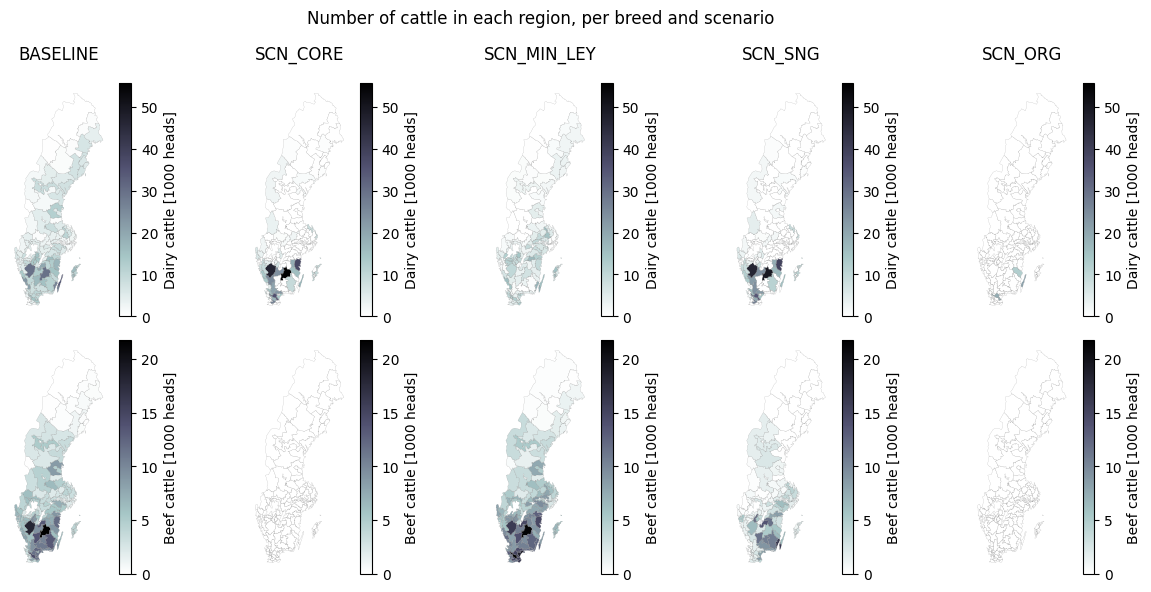

In [7]:
cattle_heads_regional = session.get_attr("a", "heads", ["species", "breed", "region"]).droplevel("year").loc[:,"cattle"]
n_scenarios = len(cattle_heads_regional.index)
fig, axs2d = plt.subplots(2, n_scenarios, figsize=(2.5*n_scenarios, 6))

cattle_heads_regional /= 1e3

vmax = { breed: cattle_heads_regional.loc[:,breed].max().max() for breed in ["dairy", "beef"] }

for scn, axs in zip(cattle_heads_regional.index.values, axs2d.T):
    for i, breed in enumerate(["dairy", "beef"]):
        ax = axs[i] 
        ax.set_axis_off()
        if i == 0:
            ax.set_title(scn)
            
        cm.plot.map_from_series(
            cattle_heads_regional.loc[scn,breed],
            ax=ax,
            legend_kwds={ "label": f"{breed.title()} cattle [1000 heads]" },
            cmap=CMAPS["map1"], edgecolor="grey",
            vmin=0, vmax=vmax[breed]
        )

fig.suptitle("Number of cattle in each region, per breed and scenario")
fig.tight_layout()
fig.subplots_adjust(left=0)
fig.savefig("figures/cattle-distribution.png", dpi=300)

In [8]:
session.get_attr("c", "area", "crop")[["Peas (add)", "Wheat (add)"]]

,crop,Peas (add),Wheat (add)
scn,year,,
BASELINE,2020,0.000000,0.000000e+00
SCN_CORE,2020,350996.647228,8.529537e+05
SCN_MIN_LEY,2020,348123.377456,4.772063e+05
SCN_SNG,2020,348478.270459,8.173265e+05
SCN_ORG,2020,350857.421918,1.037214e+06


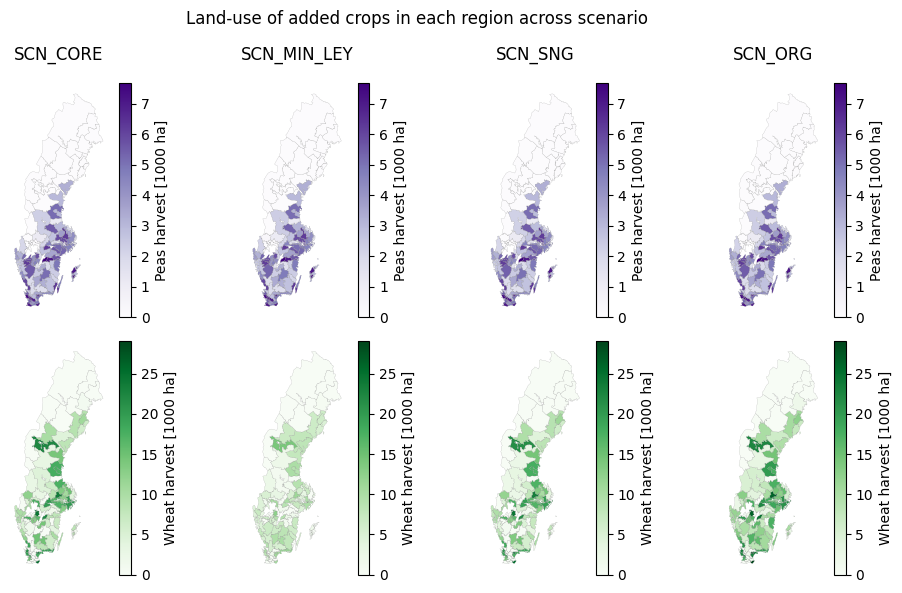

In [9]:
crops =["Peas (add)", "Wheat (add)"]
crops_regional = session.get_attr("c", "area", ["crop", "region"])[crops].droplevel("year").drop("BASELINE")
n_scenarios = len(crops_regional.index)
fig, axs2d = plt.subplots(2, n_scenarios, figsize=(2.5*n_scenarios, 6))

crops_regional /= 1e3

vmax = { cr: crops_regional.loc[:,cr].max().max() for cr in crops }

for scn, axs in zip(crops_regional.index.values, axs2d.T):
    for i, cr in enumerate(crops):
        ax = axs[i] 
        ax.set_axis_off()
        if i == 0:
            ax.set_title(scn)

        cmap = "Purples" if cr == "Peas (add)" else "Greens"
        cm.plot.map_from_series(
            crops_regional.loc[scn,cr],
            ax=ax,
            legend_kwds={ "label": f"{RENAME_MAP[cr]} harvest [1000 ha]" },
            cmap=cmap, edgecolor="grey",
            vmin=0, vmax=vmax[cr]
        )

fig.suptitle("Land-use of added crops in each region across scenario")
fig.tight_layout()
fig.subplots_adjust(left=0)
fig.savefig("figures/added-crops-distribution.png", dpi=300)

## Protein production

In [10]:
meatmilk = (
    session
    .get_attr("a", "production", ["species", "animal_prod"])
    .loc[:,"cattle"]
    .T.groupby("animal_prod").sum().T
    [["milk", "meat"]]
    .droplevel("year")
)

meatmilk / meatmilk.loc["BASELINE",:]

animal_prod,milk,meat
scn,,
BASELINE,1.000000,1.000000
SCN_CORE,0.645773,0.348272
SCN_MIN_LEY,0.678812,0.973852
SCN_SNG,0.645652,0.575356
SCN_ORG,0.062928,0.034348


In [11]:
cattle_heads = session.get_attr("a", "heads", ["species", "breed"]).loc[:,"cattle"].droplevel("year")
cattle_heads / cattle_heads.loc["BASELINE"]

breed,beef,dairy
scn,,
BASELINE,1.000000e+00,1.000000
SCN_CORE,9.901956e-11,0.632919
SCN_MIN_LEY,1.343776e+00,0.665348
SCN_SNG,5.051456e-01,0.632797
SCN_ORG,3.747574e-07,0.062474


In [12]:
crops = session.get_attr("c", "harvest", "crop")[["Peas (add)", "Wheat (add)"]].droplevel("year").drop("BASELINE")

(crops / crops.loc["SCN_CORE",:])

crop,Peas (add),Wheat (add)
scn,,
SCN_CORE,1.000000,1.000000
SCN_MIN_LEY,0.992356,0.538308
SCN_SNG,0.993312,0.959970
SCN_ORG,0.999505,1.196536


### Bar chart: How much and which sources of protein

/var/folders/r5/5hb7627n1ln48brqxcv_61bm0000gn/T/ipykernel_26205/22645169.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


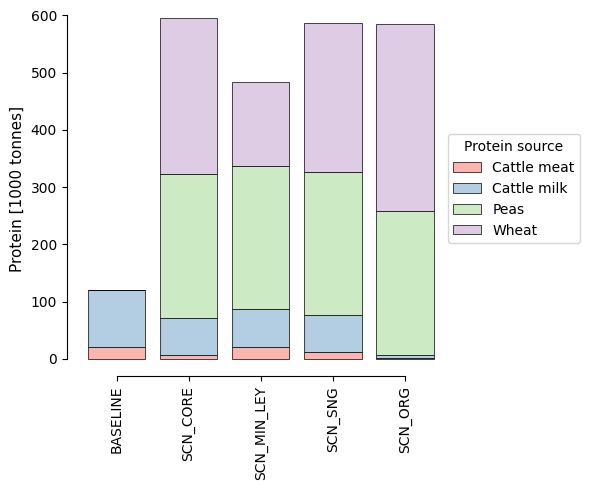

In [13]:
production = pd.concat([
    session.get_attr("a", "production").T.xs("cattle", level="species").groupby("animal_prod").sum().T[["meat", "milk"]],
    session.get_attr("c", "harvest", "crop")[["Peas (add)", "Wheat (add)"]],
], axis=1).droplevel("year").fillna(0)

for prod, factor in PROTEIN_CONTENTS.items():
    production[prod] *= factor

production = production.rename(columns=RENAME_MAP)
    
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
cm.plot.bar(production / 1e9, stacked=True, ax=ax, cmap=CMAPS["cat1"])
ax.set_ylabel("Protein [1000 tonnes]")
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title="Protein source")

#fig.suptitle("Production of added protein")
fig.tight_layout()
fig.savefig("figures/protein-production.pdf")
fig.show()

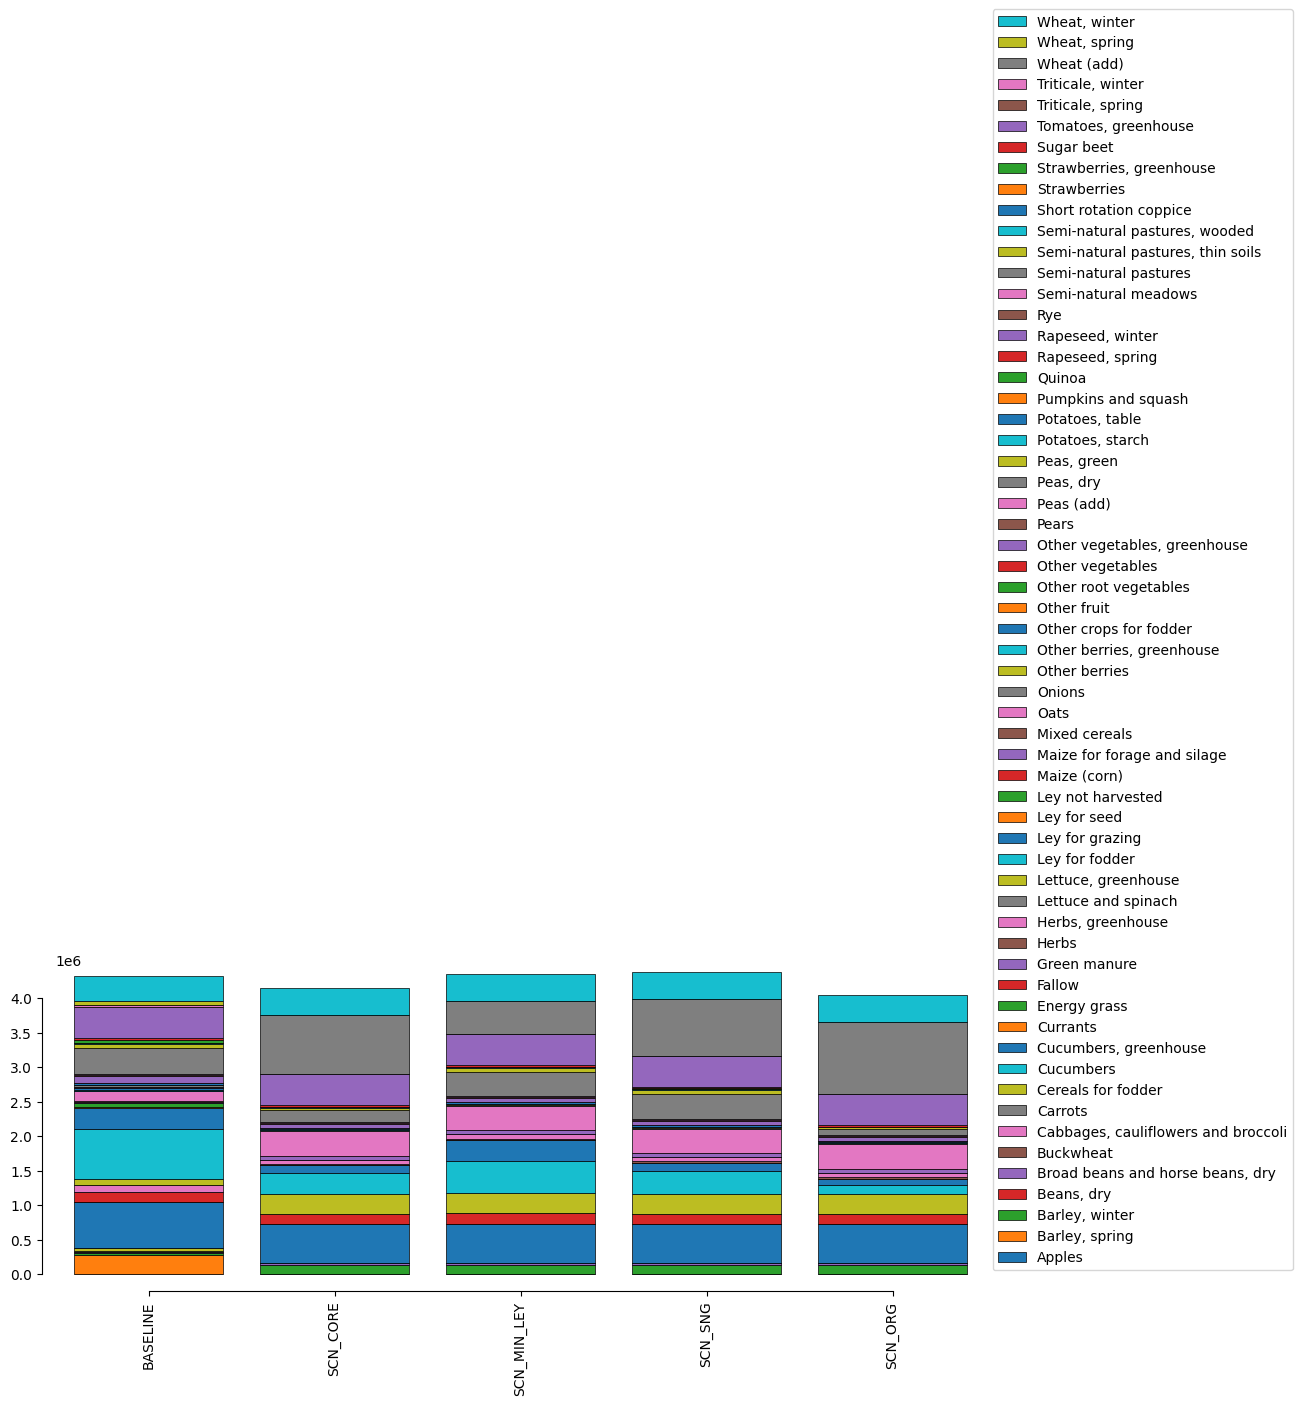

In [14]:
df = session.get_attr("C", "area", ["crop"]).droplevel("year")
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
cm.plot.bar(df, ax=ax)

handles, labels = ax.get_legend_handles_labels()
# This '::-1'-stuff is to reverse the order of handles and labels
ax.legend(handles[::-1], labels[::-1], loc='lower left', bbox_to_anchor=(1, 0))

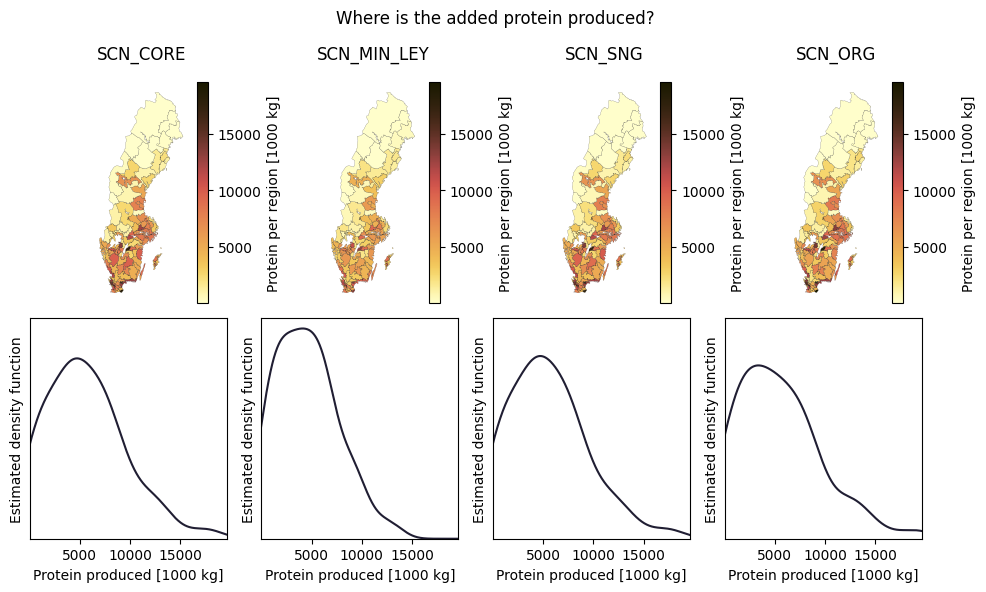

In [15]:
protein_by_region = pd.concat([
    session.get_attr("a", "production").T.xs("cattle", level="species").groupby(["animal_prod", "region"]).sum().T[["milk", "meat"]],
    session.get_attr("c", "harvest", ["crop", "region"])[["Peas (add)", "Wheat (add)"]],
], axis=1).droplevel("year").drop("BASELINE").fillna(0)

# Multiply each product by its protein contents (g protein / kg product)
for prod, factor in PROTEIN_CONTENTS.items():
    protein_by_region[prod] *= factor

# Sum across all products to get total protein amount
protein_by_region = protein_by_region.T.groupby("region").sum().T
scenarios = [scn for scn in SCENARIOS if scn != "BASELINE"]

protein_by_region /= 1e6

vmin, vmax = protein_by_region.min().min(), protein_by_region.max().max()
fig, axs2d = plt.subplots(2, len(scenarios), figsize=(len(scenarios)*2.5, 6))

for scn, ax in zip(scenarios, axs2d[0]):
    cm.plot.map_from_series(
        protein_by_region.loc[scn], ax=ax, 
        vmin=vmin, vmax=vmax, cmap=cmc.lajolla_r, edgecolor="k",
        legend_kwds={ "label": "Protein per region [1000 kg]" }
    )
    ax.set_axis_off()
    ax.set_title(scn)

max_density = 0
for scn, ax in zip(scenarios, axs2d[1]):
    protein_by_region.loc[scn].plot.kde(ax=ax, color="#201e33")
    ax.set_xlim([vmin, vmax])
    max_density = max(ax.get_ylim()[1], max_density)
    ax.set_xlabel("Protein produced [1000 kg]")
    ax.set_ylabel("Estimated density function")
    ax.yaxis.set_major_locator(mpl.ticker.NullLocator())

for ax in axs2d[1]:
    ax.set_ylim([0, max_density])
    
fig.suptitle("Where is the added protein produced?")
fig.tight_layout()
fig.savefig("figures/protein-distribution.png", dpi=300)

## Land use

### Was all land used?

In [16]:
max_lu = session.get_attr('r', 'max_land_use').droplevel("year")
scn_lu = session.get_attr('c', 'area', { "region": None, "crop": "land_use" }).droplevel("year")
share_lu = (scn_lu / max_lu).replace({np.inf: 1, np.nan: 1})

In [17]:
with pd.option_context('display.max_columns', None):
    display(share_lu.T.xs("cropland", level="land_use").T)

region,1011,111,1111,1112,112,1121,1122,1123,1124,1131,1211,1212,1213,1214,1215,1216,1221,1222,1311,1321,1322,1331,1411,1412,1421,1511,1512,1521,1522,1611,1612,1613,1614,1615,1616,1617,1621,1622,1623,1711,1712,1713,1721,1722,1723,1724,1811,1812,1813,1821,1911,1912,1921,1922,2011,2012,2019,2111,2121,2122,2211,2212,2221,2311,2312,2319,2331,2411,2412,2413,2414,2415,2419,2511,2512,2519,2521,311,312,321,322,411,421,422,431,511,512,513,514,515,521,611,612,621,622,711,731,811,812,813,814,821,831,911,912,913
scn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BASELINE,1.0,1.0,0.999752,0.99671,1.0,1.0,0.986071,0.998216,0.970284,0.985875,0.963432,0.962548,0.963733,0.977575,1.0,0.975242,0.971862,1.0,0.994223,1.0,0.990677,0.976259,0.971628,0.980334,0.983883,0.998056,0.982169,0.995052,0.965766,0.987767,1.0,0.976221,0.991001,0.992108,0.982058,0.980795,0.990879,0.983571,0.977665,1.0,0.990149,1.0,0.978151,1.0,0.994208,0.980998,1.0,0.995904,0.987852,0.984007,0.981493,0.985442,0.991022,0.982051,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,0.991427,0.980786,0.995008,0.968174,0.985449,0.977862,0.98777,0.982305,0.989724,0.982759,0.987511,0.99345,0.97665,0.964754,0.975417,0.984028,0.984921,0.984234,0.988927,1.0,0.995284,1.0,1.0,0.995093,0.966341,1.0,0.993643,1.0,1.0
SCN_CORE,1.0,1.0,1.000000,1.00000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0
SCN_MIN_LEY,1.0,1.0,1.000000,1.00000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0
SCN_SNG,1.0,1.0,1.000000,1.00000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.999998,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999999,1.0,1.0,0.999998,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0
SCN_ORG,1.0,1.0,1.000000,1.00000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000

### Land use

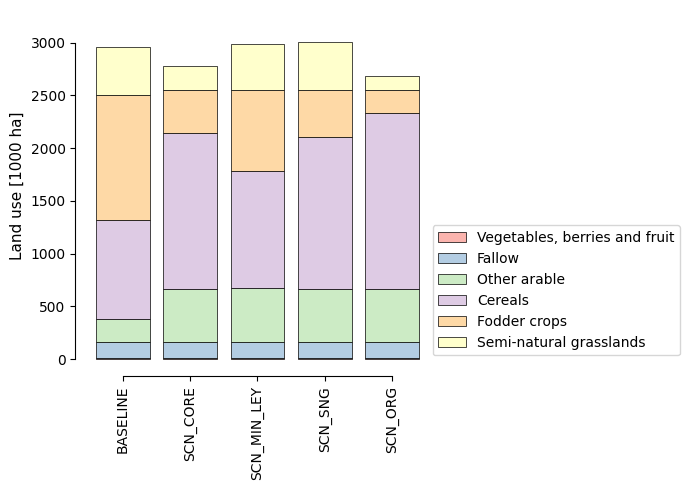

In [18]:
fig, ax = plt.subplots(figsize=(7,5))

factor = 1000
landuse_data = (
    (session.get_attr('C','area',groupby={'crop':'crop_group2'})/factor)
    .drop(['Greenhouse crops'], axis=1)
    .droplevel('year')
)

landuse_data = landuse_data.loc[:,[
    "Vegetables, berries and fruit",
    "Fallow",
    "Other arable",
    "Cereals",
    "Fodder crops",
    "Semi-natural grasslands",
]]

plot.bar(
    data=landuse_data,
    ax=ax,
    cmap=CMAPS["cat1"],
    edgecolor='k'
)

ax.tick_params(axis='y', which='major')
ax.set_xlabel('')
ax.set_ylabel(f'Land use [{factor} ha]')
ax.set_ylim(top=landuse_data.sum(axis=1).max()*1.1)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
fig.tight_layout()

fig.savefig("figures/land-use.pdf")

## Distribution of Semi-natural grasslands

crop,Semi-natural meadows,Semi-natural pastures,"Semi-natural pastures, thin soils","Semi-natural pastures, wooded"
scn,,,,
BASELINE,9849.224900,373917.943202,58488.587982,12733.337350
SCN_CORE,11997.132000,173166.794577,35995.421033,7364.824566
SCN_MIN_LEY,11997.131999,350172.580618,59385.366544,12930.685534
SCN_SNG,12440.569638,369786.387602,60052.737275,13637.438926
SCN_ORG,11997.059123,82308.342711,30598.071013,4877.366704


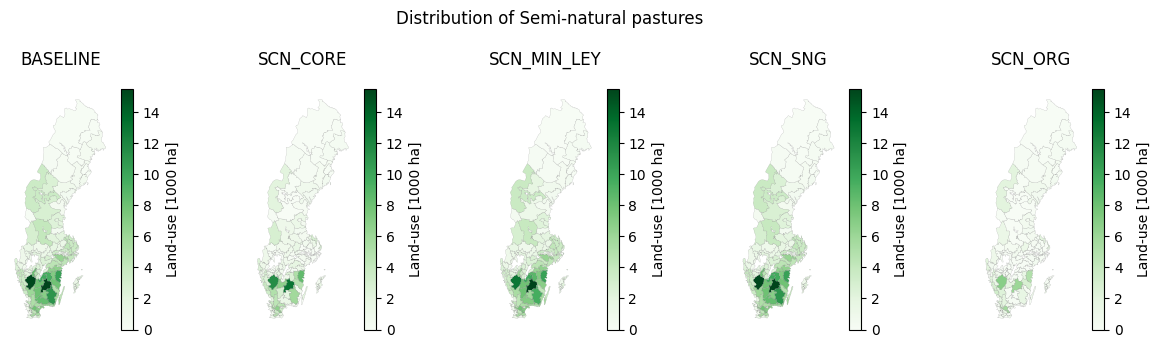

In [19]:
sng_lu = session.get_attr("C","area", ["region", "crop"]).droplevel("year").T.xs("Semi-natural pastures", level="crop").T
# Or, all SNG types:
# sng_lu = session.get_attr("C","area",{"crop": "land_use", "region": None}).droplevel("year").T.xs("semi-natural grasslands", level="land_use").T

scenarios = SCENARIOS
n_scn = len(scenarios)

sng_lu = sng_lu / 1e3
vmin = 0
vmax = sng_lu.max().max()
fig, axs = plt.subplots(1, n_scn, figsize=(n_scn * 2.5, 3.5))
for scn, ax in zip(scenarios, axs):
    ax.set_title(scn)
    ax.set_axis_off()
    
    plot.map_from_series(
        sng_lu.loc[scn], ax=ax, 
        vmin=vmin, vmax=vmax,
        edgecolor="grey",
        cmap='Greens', legend_kwds={"label": f"Land-use [1000 ha]"},
    )
    
fig.suptitle("Distribution of Semi-natural pastures")
fig.tight_layout()
fig.savefig("figures/sng-distribution.png", dpi=300)

session.get_attr("C","area",{"crop": [None, "land_use"]}).droplevel("year").T.xs("semi-natural grasslands", level="land_use").T

### Change in SNG and cropland

/var/folders/r5/5hb7627n1ln48brqxcv_61bm0000gn/T/ipykernel_26205/2027632419.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


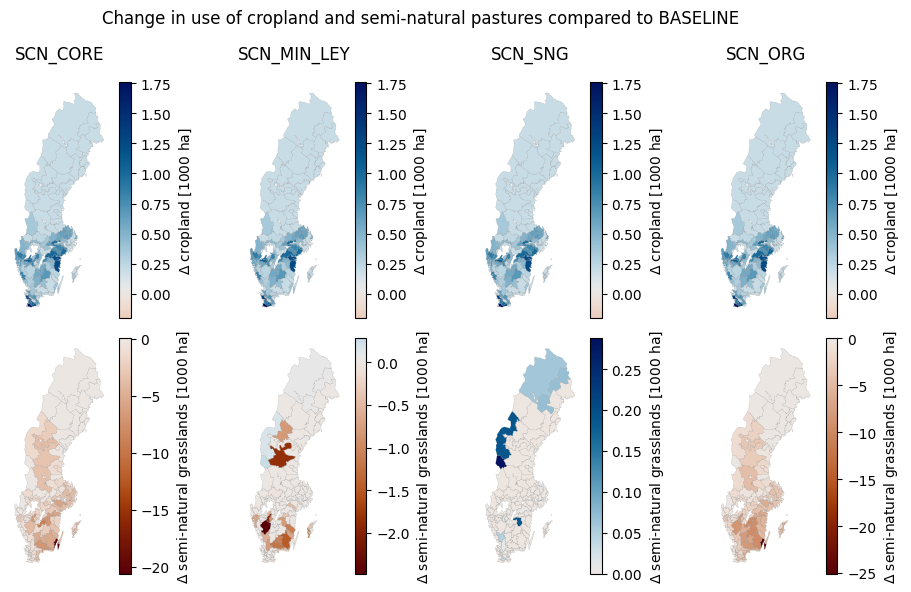

In [20]:
land_use = session.get_attr('C','area',{'crop': 'land_use', 'region':None}).droplevel("year")
land_use = (land_use - land_use.loc['BASELINE'])

scenarios = [scn for scn in land_use.index.unique("scn") if scn != "BASELINE"]
n_scn = len(scenarios)
fig, axs2d = plt.subplots(2, n_scn, figsize=(n_scn * 2.5, 6))

for scn, axs in zip(scenarios, axs2d.T):
    axs[0].set_title(scn)
    for ax, land_type in zip(axs, ["cropland", "semi-natural grasslands"]):
        data = land_use.loc[scn,:].xs(land_type, level="land_use") / 1e3
        lim = abs(data).quantile(0.99)
        ax.set_axis_off()
        plot.map_from_series(
            data, ax=ax, 
            cmap=cmc.vik_r, edgecolor='grey', 
            legend_kwds={'label': fr'$\Delta$ {land_type} [1000 ha]'},
            cmap_zero_midpoint="shrink"
        )

fig.suptitle("Change in use of cropland and semi-natural pastures compared to BASELINE")
fig.tight_layout()
fig.show()

/var/folders/r5/5hb7627n1ln48brqxcv_61bm0000gn/T/ipykernel_26205/1895198935.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


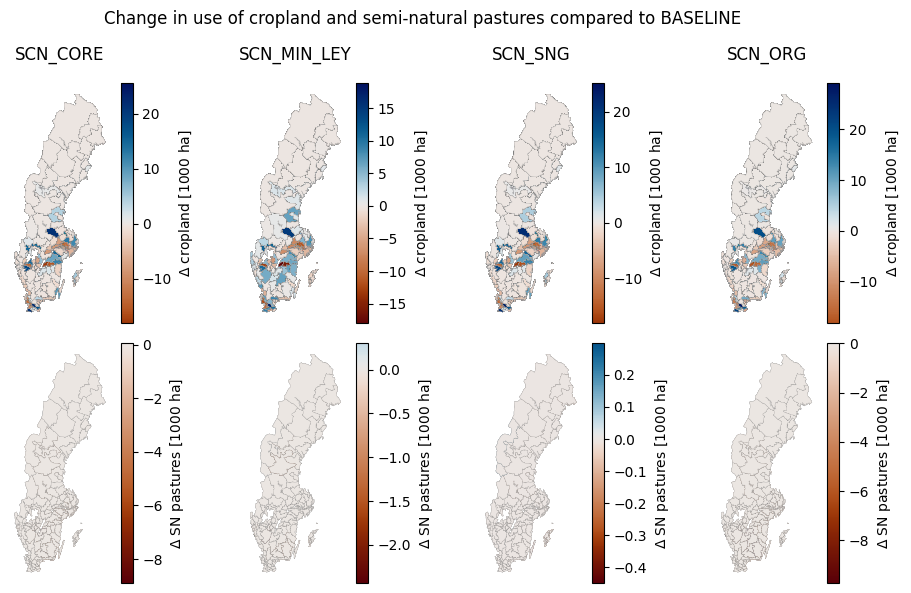

In [21]:
land_use = session.get_attr('C','area',{'crop': [None, 'land_use'], 'region':None}).droplevel("year")
# Drop non-pasture SNGs
land_use.loc[:,["Semi-natural meadows", "Semi-natural pastures, thin soils", "Semi-natural pastures, wooded"]] = 0
land_use = land_use.droplevel("crop", axis=1)

land_use = (land_use - land_use.loc['BASELINE'])

scenarios = [scn for scn in land_use.index.unique("scn") if scn != "BASELINE"]
n_scn = len(scenarios)
fig, axs2d = plt.subplots(2, n_scn, figsize=(n_scn * 2.5, 6))

for scn, axs in zip(scenarios, axs2d.T):
    axs[0].set_title(scn)
    for ax, land_type in zip(axs, ["cropland", "semi-natural grasslands"]):
        data = land_use.loc[scn,:].xs(land_type, level="land_use") / 1e3
        lim = abs(data).quantile(0.99)
        ax.set_axis_off()
        lt = "SN pastures" if land_type == "semi-natural grasslands" else land_type
        plot.map_from_series(
            data, ax=ax, 
            cmap=cmc.vik_r, edgecolor='grey', 
            legend_kwds={'label': fr'$\Delta$ {lt} [1000 ha]'},
            cmap_zero_midpoint="shrink"
        )

fig.suptitle("Change in use of cropland and semi-natural pastures compared to BASELINE")
fig.tight_layout()
#fig.savefig("figures/delta-cropland-sng.png", dpi=300)
fig.show()

### Landuse of Ley and Cereals

/var/folders/r5/5hb7627n1ln48brqxcv_61bm0000gn/T/ipykernel_26205/2739961400.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


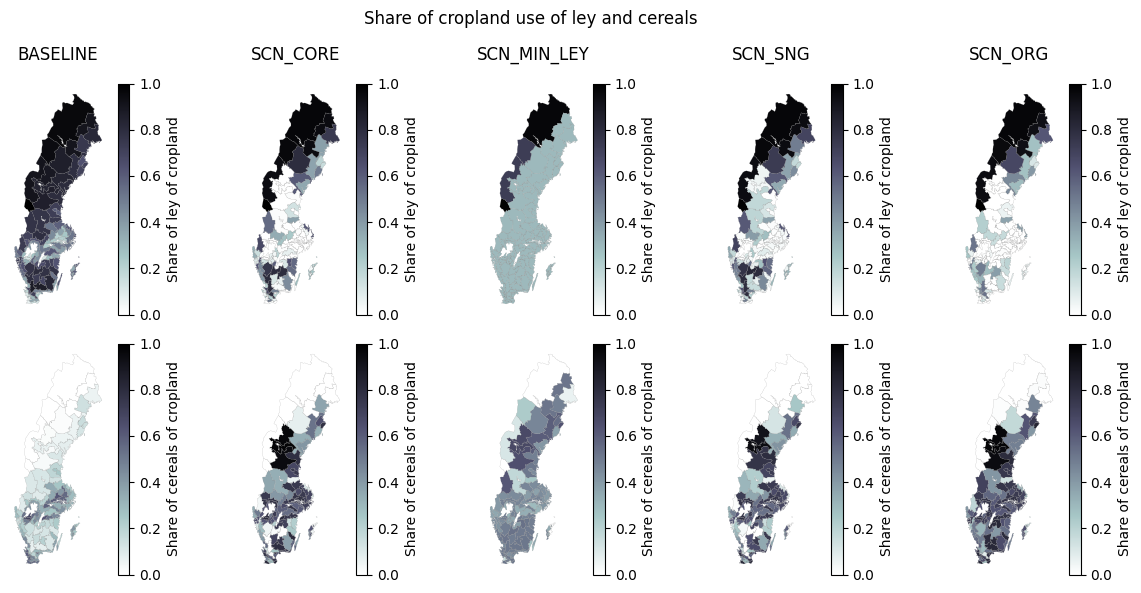

In [22]:
landuse_df = pd.concat({
    "ley": session.get_attr('C','area',groupby={'crop':'crop_group', "region": None}).droplevel("year")["Ley"],
    "cereals": session.get_attr('C','area',groupby={'crop':'crop_group', "region": None}).droplevel("year")[["Cereals, spring", "Cereals, winter"]].T.groupby("region").sum().T,
}, axis=1)
cropland_df = session.get_attr('C','area',groupby={'crop':'land_use', "region": None}).T.xs("cropland", level="land_use").T.droplevel("year")
rel_landuse_df = landuse_df/cropland_df

n_scn = len(rel_landuse_df.index)
fig, axs2d = plt.subplots(2, n_scn, figsize=(2.5*n_scn, 6))
for scn, axs in zip(rel_landuse_df.index, axs2d.T):
    axs[0].set_title(scn)
    for cg, ax in zip(["ley", "cereals"], axs):
        data = rel_landuse_df.loc[scn,(cg,slice(None))]
        ax.set_axis_off()
        plot.map_from_series(data, ax=ax, cmap=CMAPS["map1"], edgecolor="grey", vmin=0, vmax=1, legend_kwds={"label": fr"Share of {cg} of cropland"})

fig.suptitle("Share of cropland use of ley and cereals")
fig.tight_layout()
#fig.savefig("figures/share-ley-cereals-of-cropland.png")
fig.show()

### Change in crops

Plots if crops increased or decarsed in amounts in each region. 

**Disabled** because it takes about 2-3 minutes to run.

### Change in total crops per region, compared to x0

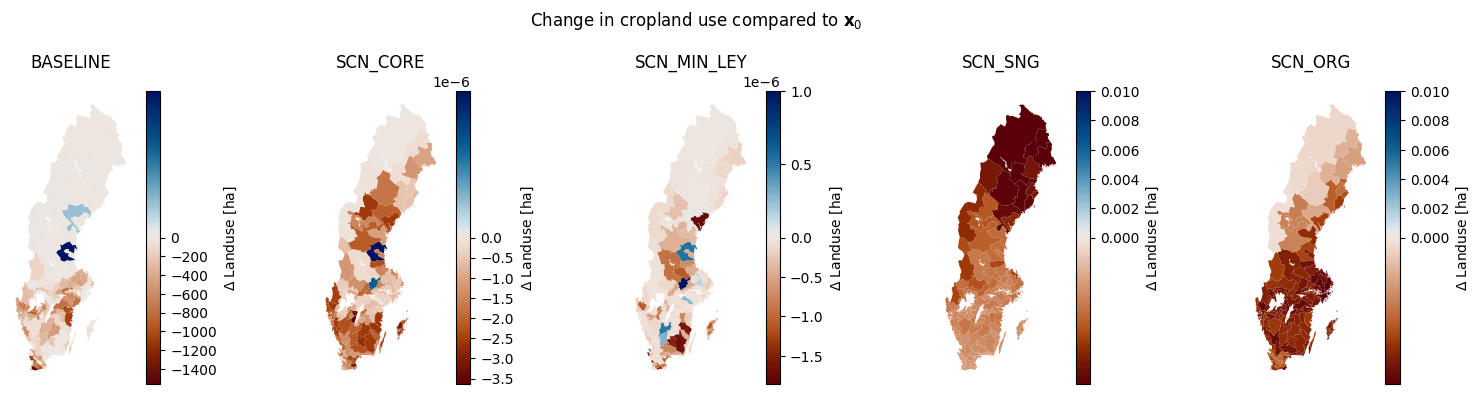

In [23]:
x0_crops_per_region = session.get_attr("r", "x0_crops", { "crop": "land_use" , "region": None, "prod_system": None })["cropland"].T.groupby(["region"]).sum().T
x_crops_per_region = session.get_attr("f", "x_crops", { "crop": "land_use", "region": None, "prod_system": None })["cropland"].T.groupby(["region"]).sum().T
delta = x_crops_per_region - x0_crops_per_region

scenarios = x0_crops_per_region.index.unique("scn")

fig, axs = plt.subplots(1, len(scenarios), figsize=(16, 4))
for scn, ax in zip(list(scenarios), axs):
    try:
        data = delta.loc[(scn, "2020"),:] 
    except Exception:
        continue

    vmin, vmax, vcenter = data.min(), data.max(), 0
    if vmin > 0:
        vmin = 0
        vcenter = 0.1
    elif vmax < 0:
        vmax = 0.01

    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    # create a normalized colorbar
    cmap=cmc.vik_r
    cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    # add colorbar
    #fig.colorbar(cbar, ax=ax2)
    
    ax.set_axis_off()
    ax.set_title(scn)
    plot.map_from_series(
        data, cmap=cmap, 
        ax=ax, norm=norm,
        vmin=vmin, vmax=vmax,
        legend_kwds={ "label": r"$\Delta$ Landuse [ha]" },
    )

fig.suptitle(r"Change in cropland use compared to $\mathbf{x}_0$")
fig.tight_layout()

### Change in total crops per region, compared to the baseline

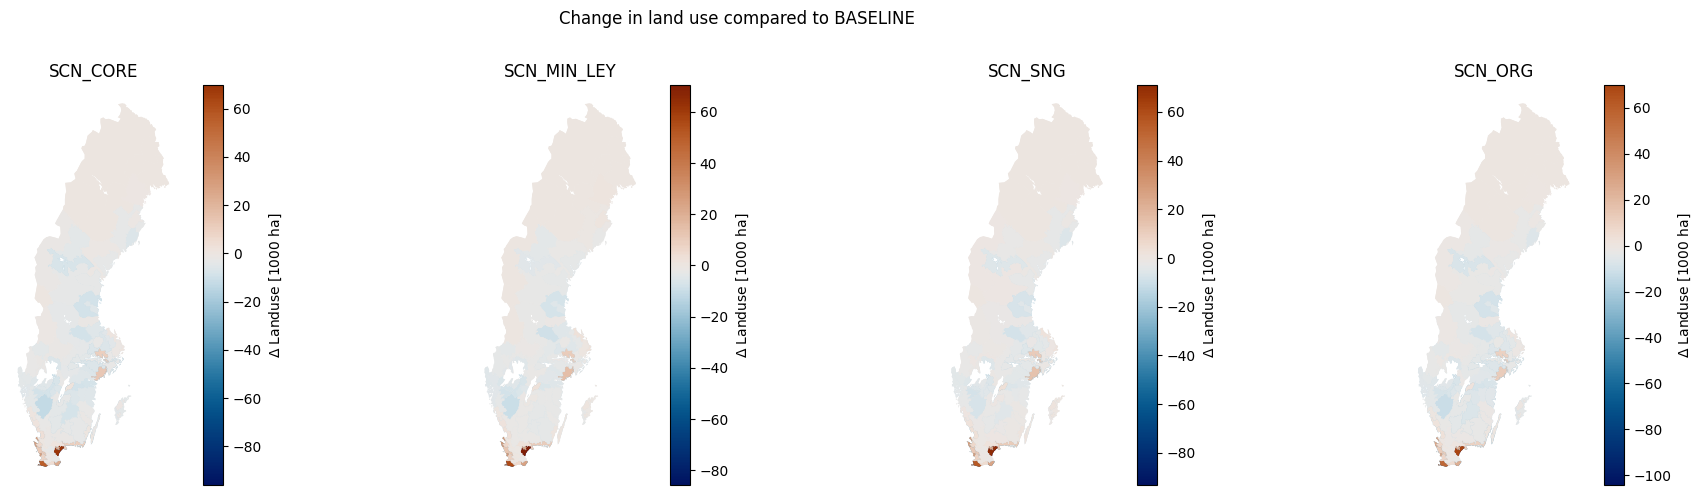

In [24]:
BL_crops_per_region = session.get_attr("r", "x0_crops", ["prod_system", "region"], scn="BASELINE").loc[("BASELINE","2020")]
SCNS_crops_per_region = session.get_attr("f", "x_crops").drop(columns=[("Wheat (add)",), ("Peas (add)",)]).T.groupby(["prod_system", "region"]).sum().T
SCNS_crops_per_region = SCNS_crops_per_region.drop([("BASELINE", "2020")])
delta = SCNS_crops_per_region - BL_crops_per_region

scenarios = [scn for scn in session.scenarios() if scn != "BASELINE"]
fig, axs = plt.subplots(1, len(scenarios), figsize=(20, 5))
for scn, ax in zip(scenarios, axs):
    ax.set_axis_off()
    ax.set_title(scn)
    
    try:
        data = delta.loc[(scn, "2020"),:] / 1e3
    except Exception:
        continue
    
    plot.map_from_series(data, cmap=cmc.vik, ax=ax, legend_kwds={ "label": r"$\Delta$ Landuse [1000 ha]" }, cmap_zero_midpoint="shrink")

fig.suptitle("Change in land use compared to BASELINE")
fig.tight_layout()

## Byproducts

### Total use and supply of by_products

/var/folders/r5/5hb7627n1ln48brqxcv_61bm0000gn/T/ipykernel_26205/3795770744.py:27: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack('flow')
/var/folders/r5/5hb7627n1ln48brqxcv_61bm0000gn/T/ipykernel_26205/3795770744.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/r5/5hb7627n1ln48brqxcv_61bm0000gn/T/ipykernel_26205/3795770744.py:27: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack('flow')
/var/folders/r5/5hb7627n1ln48brqxcv_61bm0000gn/T/ipykernel_26205/3795770744.py:53: UserWarning: FigureCanvasAgg is non

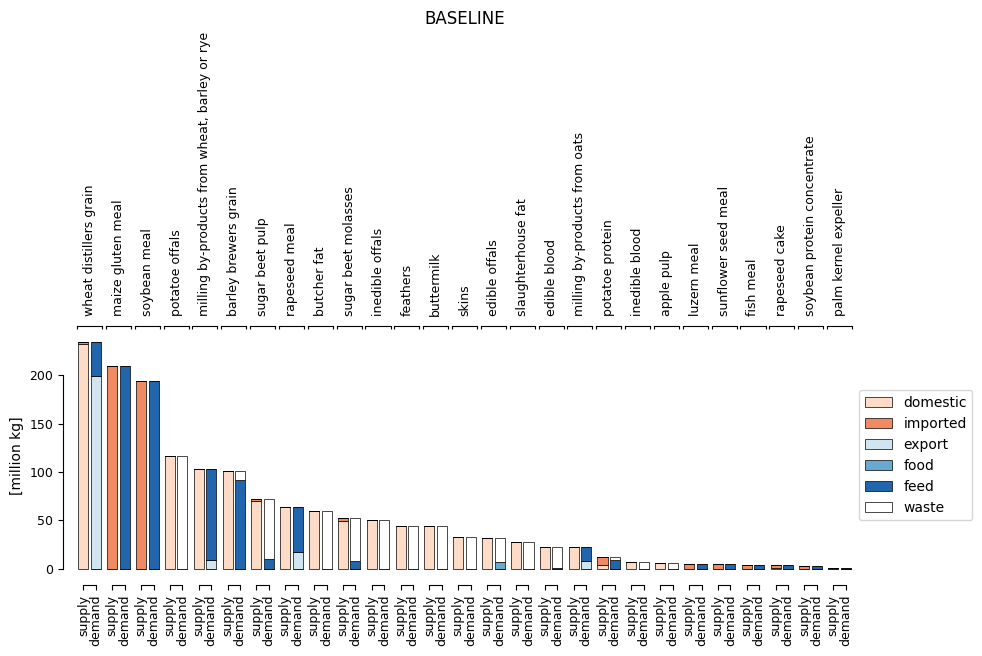

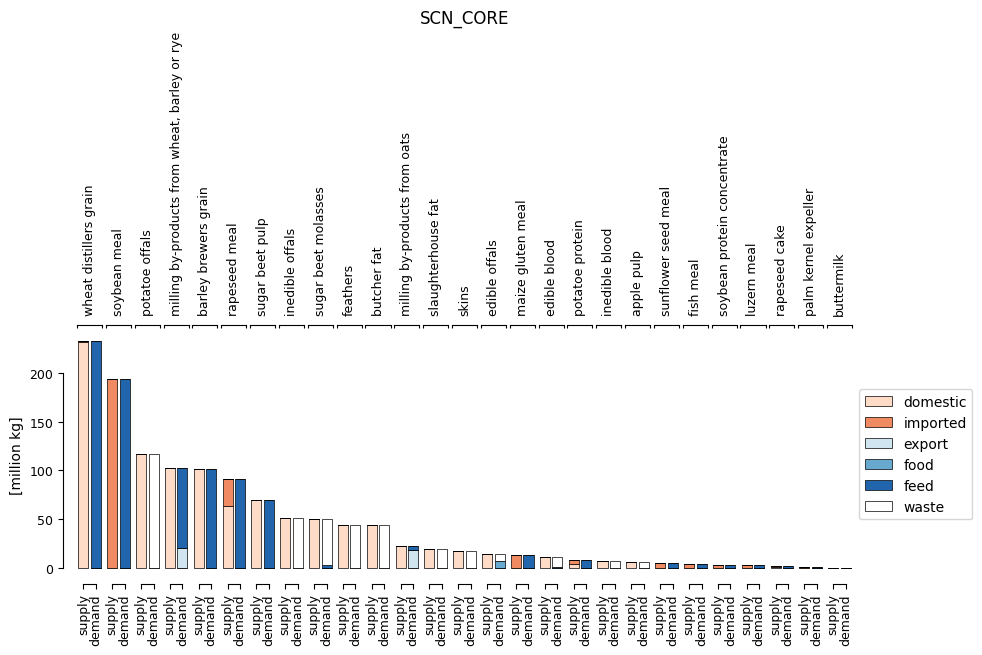

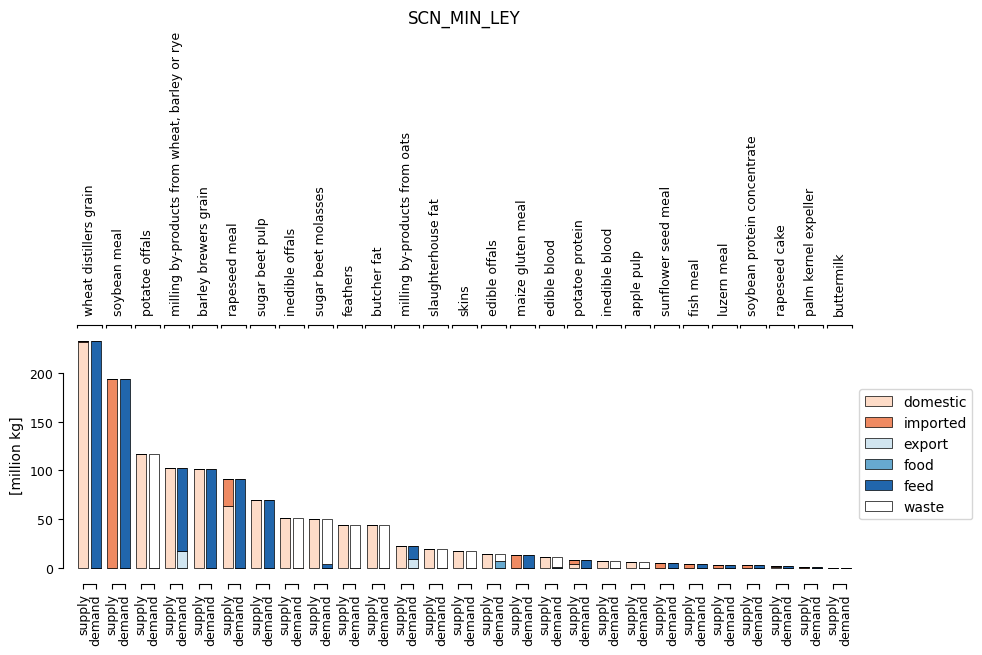

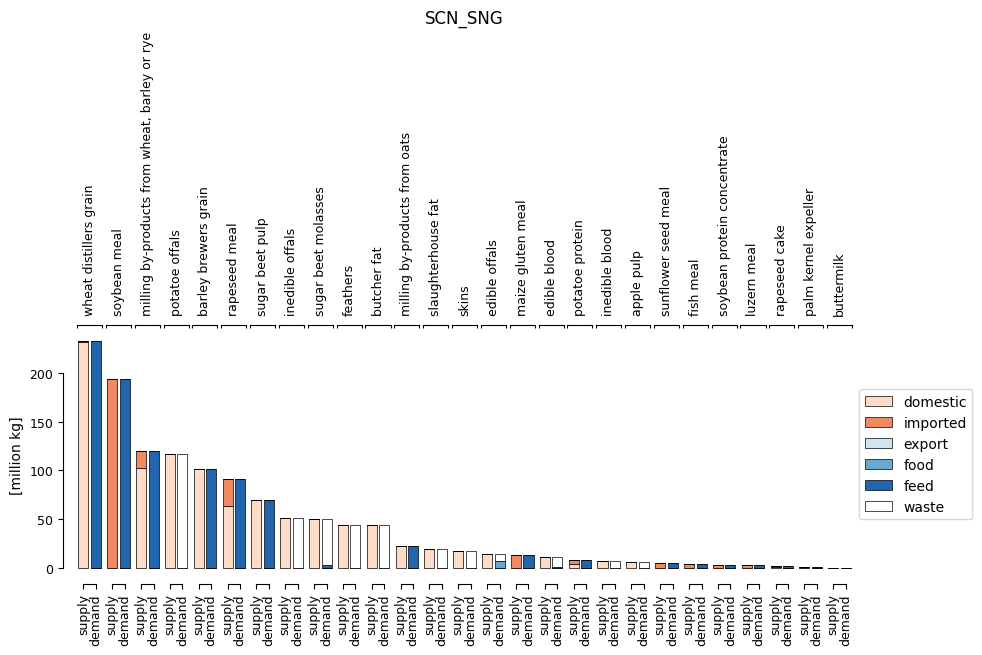

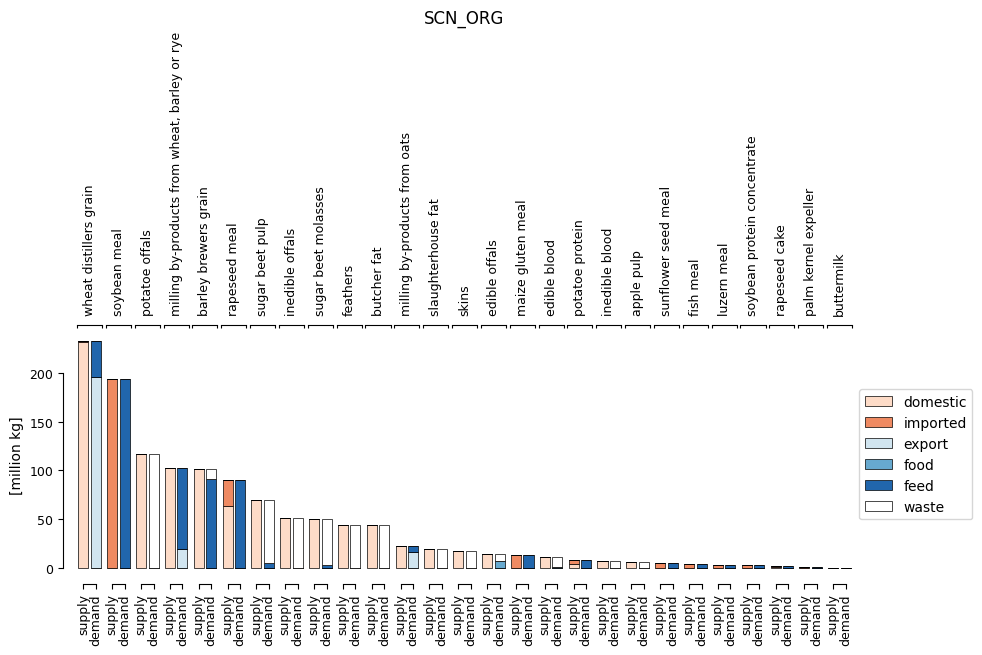

In [25]:


for scn in SCENARIOS:
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    use = pd.concat([
        # By product demand
        session.get_attr('D', 'by_prod_demand', ['by_prod', 'demand']).loc[(scn,"2020")].unstack(fill_value=0),
        # Feed
        session.get_attr('A', 'feed.by_product_demand', 'by_prod')
        .loc[(scn,"2020")]
        .rename('feed'),
        # Waste
        session.get_attr('D', 'by_prod_to_waste', 'by_prod').loc[(scn,"2020")]
        .rename('waste')
    ], axis=1).fillna(0).rename_axis('origin', axis=1)
    
    supply = (
        session.get_attr('D', 'by_products', ['by_prod', 'origin'])
        .loc[(scn,"2020")]
        .unstack()
        .fillna(0)
    )
    
    plot_data = (
        pd.concat([
            pd.concat({'supply': supply}, names=['flow'], axis=1),
            pd.concat({'demand': use }, names=['flow'], axis=1),
        ], axis=1)
        .stack('flow')
        .sort_index(level='flow', ascending=False)
        .sort_index(level='by_prod', sort_remaining=False)
        .fillna(0)
        / 1e6
    )
    
    colors = ['#fddbc7', '#ef8a62', '#d1e5f0', '#67a9cf', '#2166ac', '#ffffff']
    cust_cmap = ListedColormap(name='X', colors=colors)
    
    ax, axgs = cm.plot.bar(
        plot_data.drop('whey'),
        ax=ax,
        cmap = cust_cmap,
        group_levels='by_prod',
        sort_groups=True,
        grouplabels_vertical=True,
        group_spacing = 0.3,
        ticklabels_fontsize = 9,
        grouplabels_fontsize = 9,
        ylabel_fontsize = 10,
        xlabel_fontsize = 10
    )
    ax.set_ylabel("[million kg]")
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax.set_title(scn)
    fig.show()


### Distribution of by product usage

/var/folders/r5/5hb7627n1ln48brqxcv_61bm0000gn/T/ipykernel_26205/4278413547.py:23: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack('flow')
/var/folders/r5/5hb7627n1ln48brqxcv_61bm0000gn/T/ipykernel_26205/4278413547.py:87: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/r5/5hb7627n1ln48brqxcv_61bm0000gn/T/ipykernel_26205/4278413547.py:23: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack('flow')
/var/folders/r5/5hb7627n1ln48brqxcv_61bm0000gn/T/ipykernel_26205/4278413547.py:87: UserWarning: FigureCanvasAgg is non

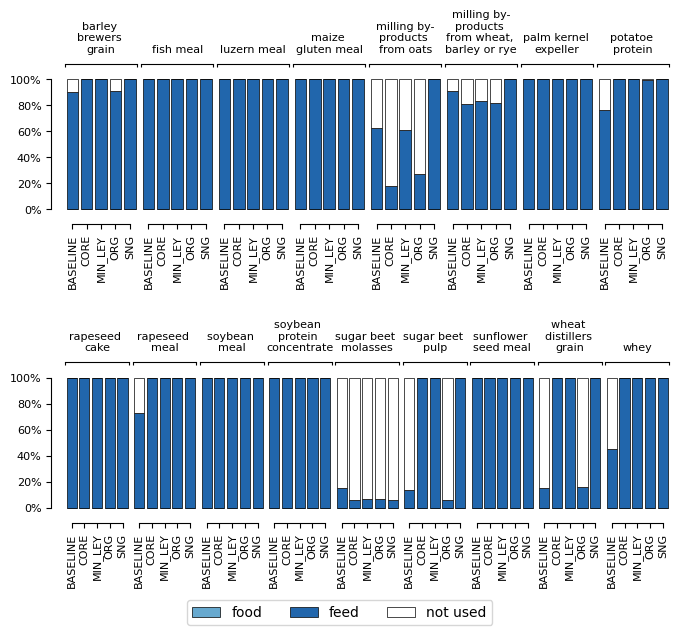

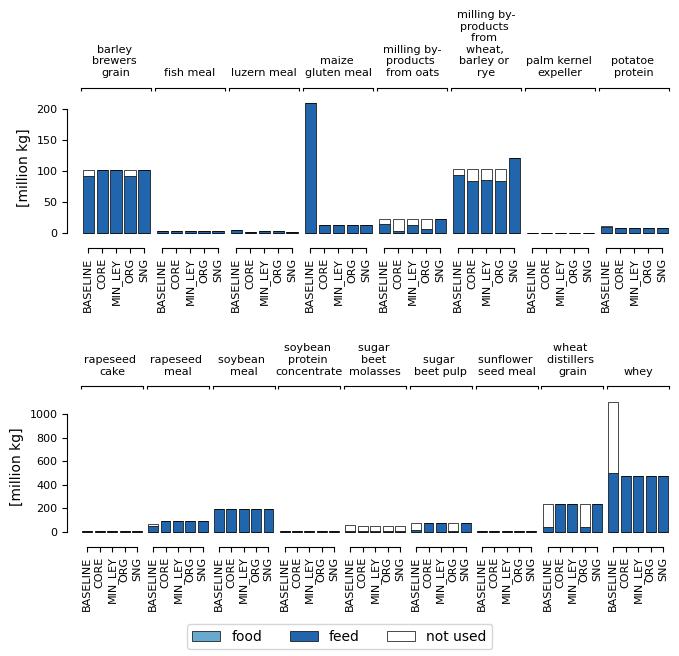

In [26]:
## from matplotlib.colors import ListedColormap

for AS_PERC in [True, False]:
    
    def get_use(scn: str):
        return pd.concat([
            # By product demand
            session.get_attr('D', 'by_prod_demand', ['by_prod', 'demand']).loc[(scn,"2020")].unstack(fill_value=0),
            # Feed
            session.get_attr('A', 'feed.by_product_demand', 'by_prod')
            .loc[(scn,"2020")]
            .rename('feed'),
            # Waste
            session.get_attr('D', 'by_prod_to_waste', 'by_prod').loc[(scn,"2020")]
            .rename('waste')
        ], axis=1).fillna(0).rename_axis('origin', axis=1)
    
    plot_data = (
        pd.concat([
            pd.concat({scn: get_use(scn)}, names=['flow'], axis=1) 
            for scn in SCENARIOS 
        ], axis=1)
        .stack('flow')
        .sort_index(level='flow', ascending=True)
        .sort_index(level='by_prod', sort_remaining=False)
        .fillna(0)
        / 1e6
    )
    
    # Remove all zero-bps
    plot_data = plot_data[plot_data.sum(axis=1) > 0]
    # Remove all bps not used as feed
    bps_with_nonzero_feeds = plot_data.index.unique("by_prod")[plot_data.groupby("by_prod").sum()["feed"] > 0]
    plot_data = plot_data.loc[bps_with_nonzero_feeds,:]
    # Join 'export' and 'waste' into 'not used'
    plot_data.loc[:,"not used"] = plot_data.loc[:,"export"] + plot_data.loc[:,"waste"]
    plot_data = plot_data.drop(columns=["export", "waste"])
    # Replace all "SCN_" prefix
    plot_data.index = pd.MultiIndex.from_tuples(
        map(lambda xs: (xs[0], xs[1].removeprefix("SCN_")), plot_data.index.values),
        names=plot_data.index.names
    )
    
    if AS_PERC:
        plot_data = (plot_data.T /  plot_data.T.sum()).T
        plot_data = plot_data[plot_data.loc[:, "not used"] != 1]
    
    colors = ["#67a9cf", "#2166ac", "#ffffff"]
    cust_cmap = ListedColormap(name='X', colors=colors)
    
    by_prods = plot_data.index.unique("by_prod").tolist()
    n = int(len(by_prods) / 2)
    bps_a, bps_b = by_prods[:n], by_prods[n:]
    
    fig, axs = plt.subplots(2, 1, figsize=(7, 6))
    for bps, ax in zip([bps_a, bps_b], axs):
        cm.plot.bar(
            plot_data.loc[bps],
            ax=ax,
            cmap = cust_cmap,
            group_levels='by_prod',
            sort_groups=False,
            grouplabels_vertical=False,
            group_spacing = 0.3,
            ticklabels_fontsize = 8,
            grouplabels_fontsize = 8,
            ylabel_fontsize = 10,
            xlabel_fontsize = 10,
        )

    handles, labels = axs.reshape(-1)[0].get_legend_handles_labels() 
    [ax.get_legend().remove() for ax in axs.reshape(-1)]
    fig.legend(handles, labels, loc="lower center", ncol=4)
    
    for ax in axs:
        if AS_PERC:
            ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1))
        else:
            ax.set_ylabel("[million kg]")
        
    # fig.suptitle("Share of byproducts usage" if AS_PERC else "Use of byproducts")
    
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.20, hspace=1.25)
    fname = f"{'share' if AS_PERC else 'use'}-of-byproducts.pdf"
    fig.savefig(f"figures/{fname}")
    fig.show()

## Feed rations

### Cattle feed demand by category

In [27]:
animal_counts_full = session.get_attr("A", "heads", ["species", "breed", "prod_system", "animal"]).droplevel("year").T.xs("cattle", level="species").T
animal_counts_full

breed                 beef                                                    \
prod_system   conventional                                                     
animal      breeding bulls         bulls  calves, bull calves, for slaughter   
scn                                                                            
BASELINE      11478.656553  35509.587800  24629.208137            567.452133   
SCN_CORE          0.000000      0.000000      0.000000              0.000000   
SCN_MIN_LEY   20320.864720  59862.286683  41520.074143            951.765587   
SCN_SNG        4968.520084  15878.924224  11013.513643            254.571049   
SCN_ORG           0.003627      0.011636      0.008071              0.000171   

breed                                                                     \
prod_system                                                                
animal      calves, heifer calves, steer calves, suckling           cows   
scn                                                                        
BASELINE      25362.916099   2517.854347     71650.765338  130091.440940   
SCN_CORE          0.000000      0.000000         0.000000       0.000046   
SCN_MIN_LEY   43580.355153   4244.614711    126844.592200  230303.133496   
SCN_SNG       11202.046237   1125.916150     31013.931376   56309.894289   
SCN_ORG           0.008198      0.000825         0.022644       0.041114   

breed                                     ...          dairy              \
prod_system                               ...        organic               
animal             heifers        steers  ... breeding bulls       bulls   
scn                                       ...                              
BASELINE      78036.276932   7796.691317  ...     256.011690  583.415219   
SCN_CORE          0.000000      0.000000  ...       9.523116   21.701863   
SCN_MIN_LEY  134463.220252  13143.711310  ...      10.608794   24.175974   
SCN_SNG       34402.612071   3486.468818  ...       9.487481   21.620657   
SCN_ORG           0.025170      0.002555  ...      10.608770   24.175942   

breed                                                                        \
prod_system                                                                   
animal      calves, bull calves, for slaughter calves, heifer calves, steer   
scn                                                                           
BASELINE      585.202346            197.753387   15338.970096   1112.741482   
SCN_CORE       21.768341              7.356025     570.578632     41.391727   
SCN_MIN_LEY    24.250030              8.194645     635.627204     46.110571   
SCN_SNG        21.686886              7.328500     568.443541     41.236843   
SCN_ORG        24.249998              8.194625     635.627150     46.110524   

breed                                                                  
prod_system                                                            
animal      calves, suckling          cows       heifers       steers  
scn                                                                    
BASELINE        10602.672748  50690.314603  25215.071699  2039.544653  
SCN_CORE          394.397954   1885.577201    937.949626    75.866926  
SCN_MIN_LEY       439.361125   2100.541487   1044.880162    84.516101  
SCN_SNG           392.922132   1878.521292    934.439832    75.583040  
SCN_ORG           439.361092   2100.541300   1044.880070    84.516102  

[5 rows x 40 columns]

In [28]:
print(animal_counts_full.T.to_latex(escape=True, float_format='{:,.0f}'.format).replace(",", " ").replace("  ", ", "))


\begin{tabular}{lllrrrrr}
\toprule
 &, & scn & BASELINE & SCN\_CORE & SCN\_MIN\_LEY & SCN\_SNG & SCN\_ORG \\
breed & prod_system & animal &, &, &, &, &, \\
\midrule
\multirow[t]{20}{*}{beef} & \multirow[t]{10}{*}{conventional} & breeding bulls & 11 479 & 0 & 20 321 & 4 969 & 0 \\
 &, & bulls & 35 510 & 0 & 59 862 & 15 879 & 0 \\
 &, & calves, bull & 24 629 & 0 & 41 520 & 11 014 & 0 \\
 &, & calves, for slaughter & 567 & 0 & 952 & 255 & 0 \\
 &, & calves, heifer & 25 363 & 0 & 43 580 & 11 202 & 0 \\
 &, & calves, steer & 2 518 & 0 & 4 245 & 1 126 & 0 \\
 &, & calves, suckling & 71 651 & 0 & 126 845 & 31 014 & 0 \\
 &, & cows & 130 091 & 0 & 230 303 & 56 310 & 0 \\
 &, & heifers & 78 036 & 0 & 134 463 & 34 403 & 0 \\
 &, & steers & 7 797 & 0 & 13 144 & 3 486 & 0 \\
\cline{2-8}
 & \multirow[t]{10}{*}{organic} & breeding bulls & 3 241 & 0 & 1 783 & 2 073 & 0 \\
 &, & bulls & 10 667 & 0 & 5 868 & 6 824 & 0 \\
 &, & calves, bull & 7 399 & 0 & 4 070 & 4 733 & 0 \\
 &, & calves, for slaughter 

/var/folders/r5/5hb7627n1ln48brqxcv_61bm0000gn/T/ipykernel_26205/2586058199.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


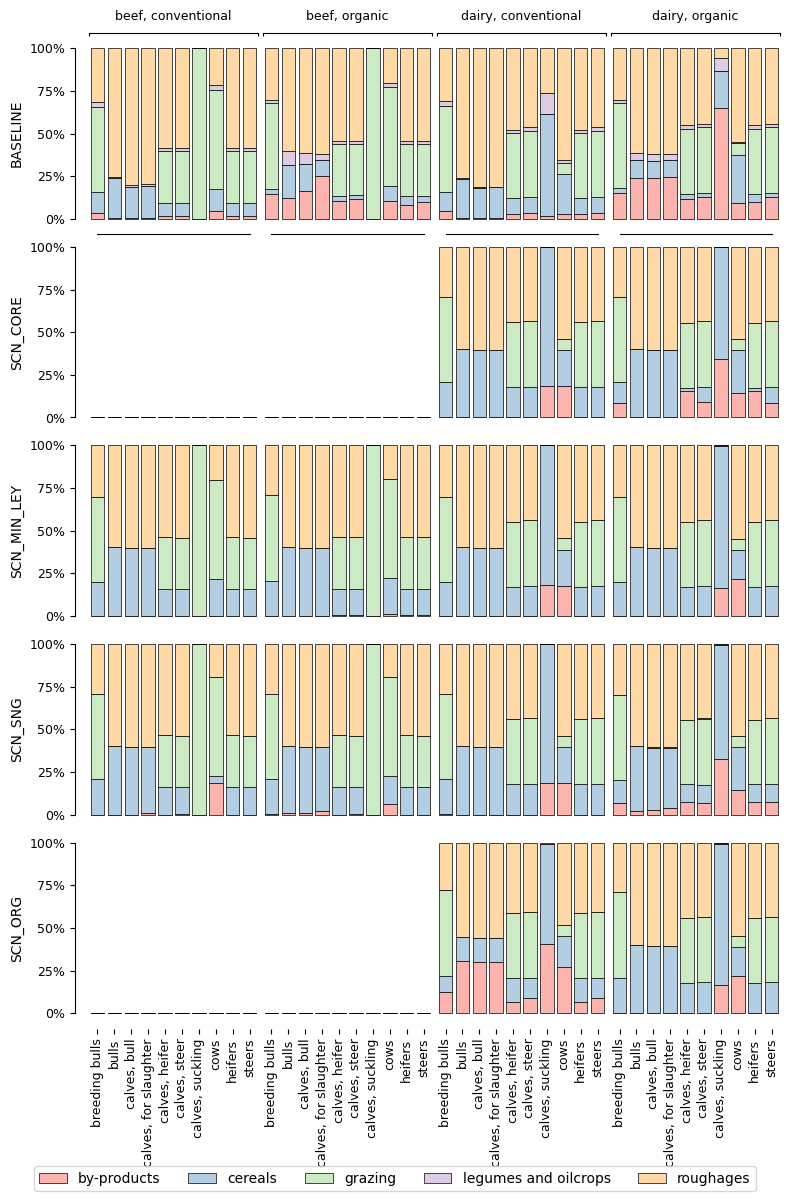

In [29]:
feed_demands = session.get_attr("A", "feed.demand", {"feed": ["feed_group2", None], "breed": None, "prod_system": None, "animal": None, "species": None}).droplevel("year").T.xs("cattle", level="species").T
feed_demands.columns = pd.MultiIndex.from_tuples(map(lambda tup: tup if not pd.isna(tup[0]) else ("by_product", *tup[1:]), feed_demands.columns.values), names=feed_demands.columns.names)
feed_demands = feed_demands.T.groupby(["feed_group2", "breed", "prod_system", "animal"]).sum().T
feed_demands_total = feed_demands.T.groupby(["breed", "prod_system", "animal"]).sum().T

fig, axs = plt.subplots(len(SCENARIOS), 1, figsize=(8, (len(SCENARIOS)-1)*2 + 4))
for scn, ax in zip(SCENARIOS, axs):
    data = (feed_demands.loc[scn].unstack("feed_group2").T / feed_demands_total.loc[scn]).T.sort_index()
    data = data.sort_index()

    # Set values to 0 wherever there are zero animals, making sub-subfigures blank.
    for (br, ps, ani) in data.index:
        if animal_counts_full.loc[scn, (br, ps, ani)] < 1:
            data.loc[(br, ps, ani),:] = 0
            
    _axs, _grp_axs = cm.plot.bar(
        data,
        ax=ax,
        cmap = "Pastel1",
        group_levels=["breed", "prod_system"],
        sort_groups=False,  # Use the already-sorted index instead
        grouplabels_vertical=False, 
        group_spacing = 0.3,
        ticklabels_fontsize = 9,
        grouplabels_fontsize = 9,
        ylabel_fontsize = 10,
        xlabel_fontsize = 10
    )

    if ax != axs[0]:
        for _grp_ax in _grp_axs:
            _grp_ax.remove()

    if ax != axs[-1]:
        ax.set_xticks([], minor=False) # Remove the ticks along the bottom
    
    ax.set_ylabel(scn)
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1))


## Remove all the subplot-legends and add a common one for the entire figure
handles, labels = axs.reshape(-1)[0].get_legend_handles_labels() 
[ax.get_legend().remove() for ax in axs.reshape(-1)]
fig.legend(handles, labels, loc="lower center", ncol=5)
    
fig.tight_layout()
fig.subplots_adjust(bottom=.15)  # Make space for the extra legend
fig.savefig("figures/feed-rations.pdf")
fig.show()

In [30]:
session.get_attr("A", "feed.by_product_demand", ["species", "by_prod"]).droplevel("year").loc[:,("cattle", )]

by_prod,barley brewers grain,maize gluten meal,milling by-products from oats,"milling by-products from wheat, barley or rye",potatoe protein,rapeseed cake,rapeseed meal,sugar beet molasses,sugar beet pulp,wheat distillers grain,whey
scn,,,,,,,,,,,
BASELINE,6.038709e+06,1.965066e+08,5.302748e+06,5.213473e+06,4.101788e+06,1.947679e+06,0.000000e+00,2.880507e+06,2.064993e+06,1.811040e+06,2.559581e+07
SCN_CORE,1.596320e+07,0.000000e+00,2.725686e+05,2.428770e-01,2.895730e+06,6.008245e+05,4.446025e+07,5.208613e-02,6.584271e+07,1.993068e+08,0.000000e+00
SCN_MIN_LEY,1.596320e+07,0.000000e+00,9.117185e+06,1.554933e+06,2.893972e+06,6.008245e+05,4.446025e+07,1.949702e-01,6.546327e+07,1.993068e+08,0.000000e+00
SCN_SNG,1.596058e+07,0.000000e+00,1.823823e+07,3.726504e+07,2.895301e+06,6.007965e+05,4.445993e+07,3.811213e+04,6.577901e+07,1.993052e+08,0.000000e+00
SCN_ORG,6.190957e+06,0.000000e+00,1.856159e+06,2.454643e+04,2.850005e+06,6.681574e+00,4.377303e+07,1.088208e+04,1.116094e+04,3.186622e+06,0.000000e+00


In [31]:
feed_by_prod = session.get_attr("A", "feed.by_product_demand", ["species"]).droplevel("year").loc[:,"cattle"]
feed_by_prod

scn
BASELINE       2.514633e+08
SCN_CORE       3.293421e+08
SCN_MIN_LEY    3.393605e+08
SCN_SNG        3.845422e+08
SCN_ORG        5.790337e+07
Name: cattle, dtype: float64

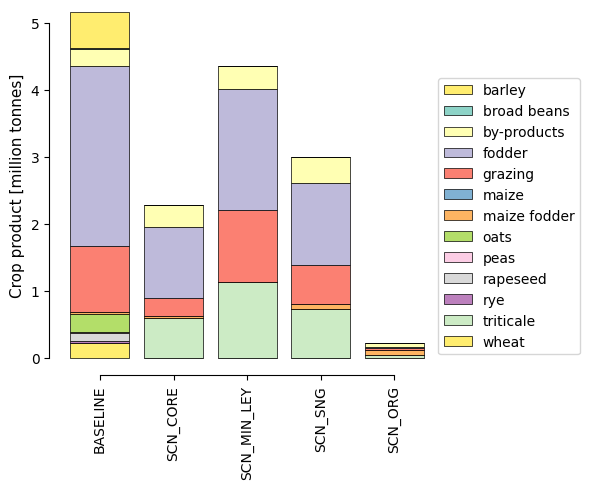

In [32]:
feed_crop_prod = session.get_attr("A", "feed.crop_product_demand", ["species", "origin", "crop_prod"]).droplevel("year").loc[:,("cattle", "domestic", )]
feed_crop_prod.loc[:,"by-products"] = session.get_attr("A", "feed.by_product_demand", ["species"]).droplevel("year").loc[:,"cattle"]
feed_crop_prod /= 1e9
feed_crop_prod = feed_crop_prod.sort_index(axis=1, ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot.bar(feed_crop_prod, ax=ax, cmap="Set3_r")
ax.set_ylabel("Crop product [million tonnes]")

handles, labels = ax.get_legend_handles_labels()
# This '::-1'-stuff is to reverse the order of handles and labels
ax.legend(handles[::-1], labels[::-1], loc='lower left', bbox_to_anchor=(1, 0))

fig.tight_layout()
fig.savefig("figures/feed-crop-product.pdf")

In [33]:
feed_crop_prod.sum(axis=1) / feed_crop_prod.sum(axis=1).loc["BASELINE"]

scn
BASELINE       1.000000
SCN_CORE       0.442705
SCN_MIN_LEY    0.844933
SCN_SNG        0.581857
SCN_ORG        0.041718
dtype: float64

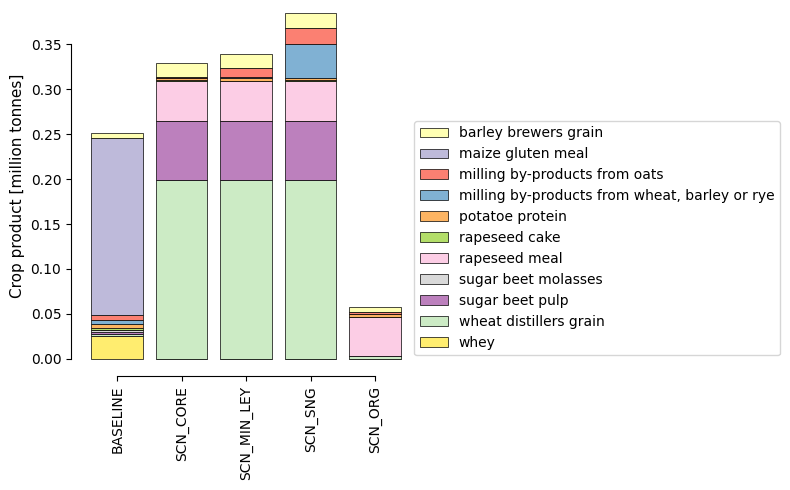

In [34]:
by_crop_prod = session.get_attr("A", "feed.by_product_demand", ["species", "by_prod"]).droplevel("year").loc[:,("cattle", )]
by_crop_prod /= 1e9

by_crop_prod = by_crop_prod.sort_index(axis=1, ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plot.bar(by_crop_prod, ax=ax, cmap="Set3_r")
ax.set_ylabel("Crop product [million tonnes]")
handles, labels = ax.get_legend_handles_labels()
# This '::-1'-stuff is to reverse the order of handles and labels
ax.legend(handles[::-1], labels[::-1], loc='lower left', bbox_to_anchor=(1, 0))

fig.tight_layout()
fig.savefig("figures/by-crop-product.pdf")

In [35]:
df = session.get_attr("a", "feed.consumption", {"species":None, "feed": "feed_group"}).droplevel("year").loc[:,"cattle"]
df / df.loc["BASELINE"]

feed_group,dry concentrates,grazing,hay and straw,ley silage,other silage,wet concentrates
scn,,,,,,
BASELINE,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00
SCN_CORE,0.689784,0.274741,3.478464,0.399431,0.281904,1.806403e-08
SCN_MIN_LEY,1.087142,1.090685,4.789841,0.685998,0.240940,6.768529e-08
SCN_SNG,0.830145,0.587032,4.560604,0.463450,0.779741,1.323105e-02
SCN_ORG,0.071414,0.025648,0.294657,0.003994,0.707630,3.777834e-03


In [36]:
df = (
    session.get_attr("a", "feed.consumption", ["species", "feed"])
    .droplevel("year")
    .loc[:,"cattle"]
    .loc[:,"straw"]
)
df / df.loc["BASELINE"]

scn
BASELINE       1.000000
SCN_CORE       3.478464
SCN_MIN_LEY    4.789841
SCN_SNG        4.560604
SCN_ORG        0.294657
Name: straw, dtype: float64

### Map over where feed is produced

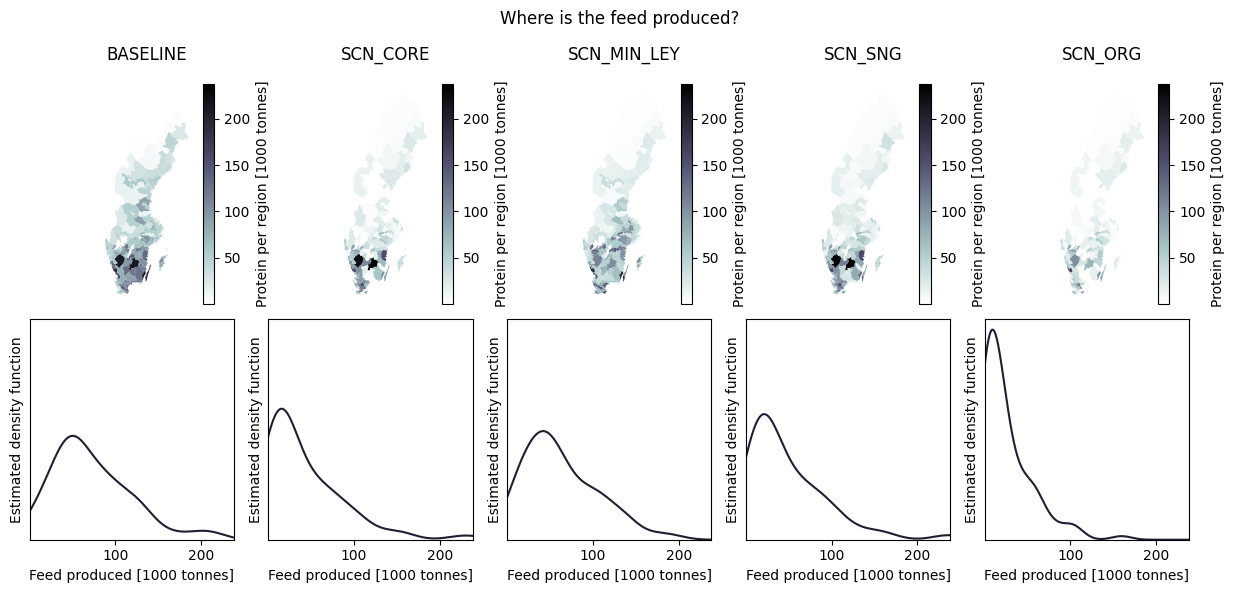

In [37]:
feed_by_region = session.get_attr("a", "feed.crop_product_demand", "region").droplevel("year").fillna(0)

feed_by_region /= 1e6

vmin, vmax = feed_by_region.min().min(), feed_by_region.max().max()
scenarios=SCENARIOS
fig, axs2d = plt.subplots(2, len(scenarios), figsize=(len(scenarios)*2.5, 6))

for scn, ax in zip(scenarios, axs2d[0]):
    cm.plot.map_from_series(
        feed_by_region.loc[scn], 
        ax=ax, cmap="bone_r",
        vmin=vmin, vmax=vmax, 
        legend_kwds={ "label": "Protein per region [1000 tonnes]" }
    )
    ax.set_axis_off()
    ax.set_title(scn)

max_density = 0
for scn, ax in zip(scenarios, axs2d[1]):
    feed_by_region.loc[scn].plot.kde(ax=ax, color="#201e33")
    ax.set_xlim([vmin, vmax])
    max_density = max(ax.get_ylim()[1], max_density)
    ax.set_xlabel("Feed produced [1000 tonnes]")
    ax.yaxis.set_major_locator(mpl.ticker.NullLocator())
    ax.set_ylabel("Estimated density function")

for ax in axs2d[1]:
    ax.set_ylim([0, max_density])

fig.suptitle("Where is the feed produced?")
fig.savefig("figures/feed-distribution.png", dpi=300)
fig.tight_layout()

## Chloropleth maps over added crops/meat

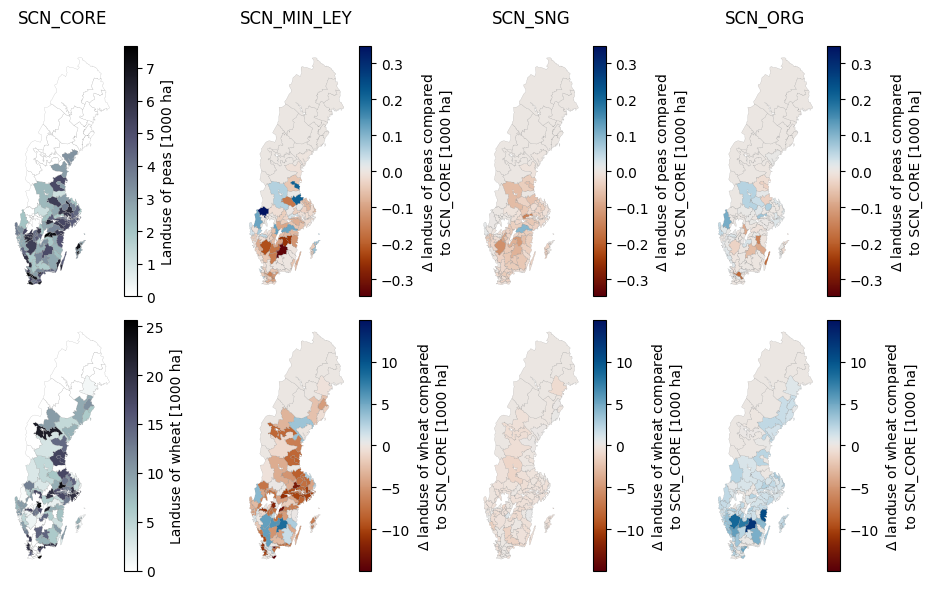

In [38]:
CROPS = ["Peas (add)", "Wheat (add)"]
crops = session.get_attr("c", "area", ["crop", "region"]).loc[:,CROPS].droplevel("year").drop("BASELINE") / 1e3

nrows = len(CROPS)
ncols = crops.shape[0]
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.5, nrows*3))

if nrows == 1:
    axs = [axs]

vmin = { crp: (crops.loc[:, crp] - crops.loc["SCN_CORE", crp]).min().min() for crp in CROPS }
vmax = { crp: (crops.loc[:, crp] - crops.loc["SCN_CORE", crp]).max().max() for crp in CROPS }

for crp in CROPS:
    _min, _max = vmin[crp], vmax[crp]
    if _min*_max > 0:
        continue
    val = max(-_min, _max)
    vmin[crp] = -max(-_min, _max)
    vmax[crp] = max(-_min, _max) 

for scn_i, scn in enumerate(crops.index):
    for crp_i, crp in enumerate(CROPS):
        data=crops.loc[scn,crp]
        ax=axs[crp_i][scn_i]
        ax.set_axis_off()

        if crp_i == 0:
            ax.set_title(scn)

        crop = RENAME_MAP[crp].lower()
        if scn == "SCN_CORE":
            cm.plot.map_from_series(
                data, 
                ax=ax, 
                cmap=CMAPS["map1"],
                edgecolor="grey",
                legend_kwds={ "label": f"Landuse of {crop} [1000 ha]" }
            )
        else:
            data = data - crops.loc["SCN_CORE", crp]
            cm.plot.map_from_series(
                data, ax=ax, 
                cmap=cmc.vik_r, edgecolor="grey", 
                vmin=vmin[crp], vmax=vmax[crp],
                legend_kwds={ "label": fr"$\Delta$ landuse of {crop} compared" +  "\nto SCN_CORE [1000 ha]" }
            )

fig.tight_layout()
fig.savefig("figures/landuse-added-crops.png", dpi=300)

# Impacts

## Greenhouse gases

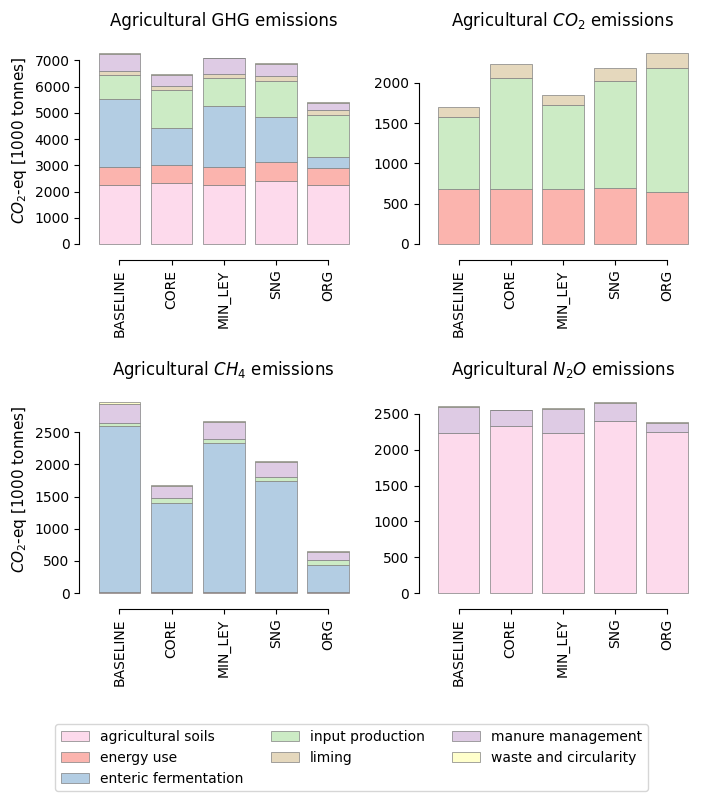

In [39]:
import matplotlib as mpl

ghg_impacts = (
    cm.impact.get_GHG(session)
    .T.groupby(['compound','process']).sum().T
    .droplevel('year')
)/1e6

def plot_ghg(
    ghgs: list[str] | str | slice,
    title: str,
    ax: plt.Axes | None = None,
    color_map: dict[str, tuple] | None = None
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))

    if isinstance(ghgs, str):
        ghgs = [ghgs]

    data = ghg_impacts.loc[:,ghgs].T.groupby('process').sum().T

    plot.bar(
        data=data,
        ax=ax,
        edgecolor='grey',
        cmap="Pastel1"
    )

    # Manually set color of each bar to the defined color_map
    if color_map:
        n_scenarios = len(data.index)
        colors = [color_map[cat] for cat in data.columns.unique("process")]
        rects = list(
            filter(lambda x: isinstance(x, mpl.patches.Rectangle), ax.get_children())
        )
        for i, c in enumerate(colors):
            for scn_i in range(0, n_scenarios):
                rects[i * n_scenarios + scn_i].set_facecolor(c)

    ax.set_title(title)
    ax.tick_params(axis='y', which='major')
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_ylim(top=data.sum(axis=1).max()*1.1)
    ax.legend()

# Create a dict mapping category -> color so that we get consistent color-assignments across
# all subplots (e.g. 'energy use' always has the same color)
categories = ghg_impacts.columns.unique("process").values
cmap = plt.get_cmap('Pastel1', len(categories)+1)
color_map = {category: cmap(i) for i, category in enumerate(categories)}

# Draw plots
fig, axs = plt.subplots(2, 2, figsize=(6, 8))
plot_ghg(pd.IndexSlice[:], title="Agricultural GHG emissions", ax=axs[0][0], color_map=color_map)
plot_ghg("CO2", title=r"Agricultural $CO_2$ emissions", ax=axs[0][1], color_map=color_map)
plot_ghg(["CH4bio", "CH4fos"], title=r"Agricultural $CH_4$ emissions", ax=axs[1][0], color_map=color_map)
plot_ghg(["N2O", "N2Oind"], title=r"Agricultural $N_2O$ emissions", ax=axs[1][1], color_map=color_map)

for ax in (axs[0][0], axs[1][0]):
    ax.set_ylabel(r"$CO_2$-eq [1000 tonnes]")

# Adjust plots
# ------------

## Remove all the subplot-legends and add a common one for the entire figure
co2e_handles, co2e_labels = axs[0][0].get_legend_handles_labels() 
[ax.get_legend().remove() for ax in axs.reshape(-1)]
fig.legend(co2e_handles, co2e_labels, loc="lower center", ncol=3)

## Remove SCN_ as prefix from xtick-labels to get save space
for ax in axs.reshape(-1):
    ax.set_xticklabels([
        item.get_text().removeprefix("SCN_") 
        for item in ax.get_xticklabels()
    ])

## Control the spacing 
fig.tight_layout()
fig.subplots_adjust(left=0, right=1, wspace=0.3, hspace=0.65, bottom=.25)
fig.savefig("figures/ghg-emissions.pdf", bbox_inches='tight')

## Mineral N use

In [40]:
session.get_attr("c", "energy_use_emissions", ["crop", "activity"])[["Peas (add)", "Wheat (add)"]]

,crop,Peas (add),Wheat (add)
,activity,field machinery,field machinery
scn,year,,
BASELINE,2020,0.000000e+00,0.000000e+00
SCN_CORE,2020,6.032294e+07,1.630076e+08
SCN_MIN_LEY,2020,5.984908e+07,9.087790e+07
SCN_SNG,2020,5.989605e+07,1.570023e+08
SCN_ORG,2020,6.030969e+07,1.958809e+08


In [41]:
session.get_attr("a", "energy_use_emissions", ["species", "activity"])["cattle"]

,activity,stable machinery
scn,year,
BASELINE,2020,9.120390e+07
SCN_CORE,2020,4.132367e+07
SCN_MIN_LEY,2020,7.898545e+07
SCN_SNG,2020,5.467798e+07
SCN_ORG,2020,4.057379e+06


/var/folders/r5/5hb7627n1ln48brqxcv_61bm0000gn/T/ipykernel_26205/1557839905.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


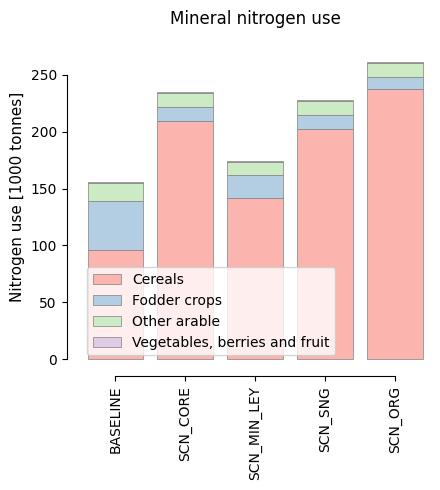

In [42]:
fig, ax = plt.subplots(figsize=(4.5,5))

mineral_use_data = (
    (session.get_attr('c','fertiliser.mineral_N', groupby={'crop':'crop_group2'}) / 1e6)
    .drop(['Greenhouse crops','Semi-natural grasslands'], axis=1, errors='ignore')
    .droplevel('year')
)

plot.bar(
    data=mineral_use_data,
    ax=ax,
    cmap=CMAPS["cat1"],
    edgecolor="grey",
)

ax.set_title("Mineral nitrogen use")
ax.tick_params(axis="y", which="major")
ax.set_xlabel("")
ax.set_ylabel('Nitrogen use [1000 tonnes]')
ax.set_ylim(top=mineral_use_data.sum(axis=1).max()*1.1)
ax.legend()

fig.tight_layout()
fig.show()

## N and P application

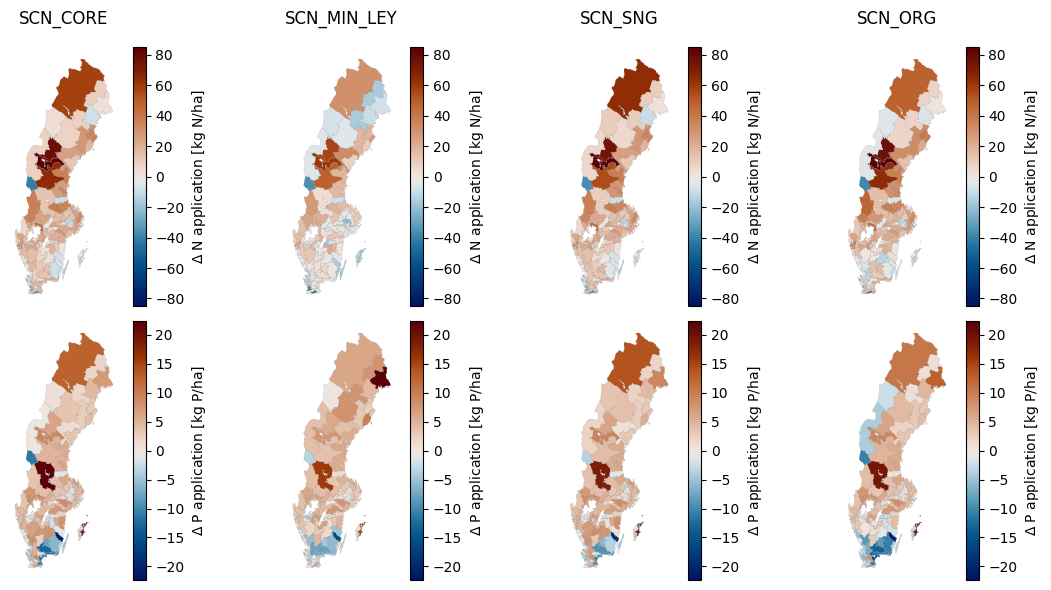

In [43]:
# CHANGES IN N AND P APPLICATION

scenarios = SCENARIOS[1:]

plot_data_N = (
    (session.get_attr('C','fertiliser.manure_N', {'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
    + session.get_attr('C','fertiliser.mineral_N', {'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1))
    /
    session.get_attr('C','area',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
).droplevel("year")

plot_data_P = (
    (session.get_attr('C','fertiliser.manure_P',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
    + session.get_attr('C','fertiliser.mineral_P',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1))
    /
    session.get_attr('C','area',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
).droplevel("year")

plot_data_N_rel = (plot_data_N - plot_data_N.loc['BASELINE'])
plot_data_P_rel = (plot_data_P - plot_data_P.loc['BASELINE'])


get_vlims = lambda vmin, vmax: (vmin, -vmin) if abs(vmin) > abs(vmax) else (-vmax, vmax)
lims = {
    "N": get_vlims(plot_data_N_rel.loc["SCN_CORE"].min(), plot_data_N_rel.loc["SCN_CORE"].max()),
    "P": get_vlims(plot_data_P_rel.loc["SCN_CORE"].min(), plot_data_P_rel.loc["SCN_CORE"].max())
}

fig, axs2d = plt.subplots(2, len(scenarios), figsize=(3*(len(scenarios)), 6))

styles = { 
    "cmap": cmc.vik,
    "edgecolor": "grey"
}

for scn, axs in zip(scenarios, axs2d.T):   
    for map_data, ax, label, vlims in [
        (plot_data_N_rel.loc[scn], axs[0], r'$\Delta$ N application [kg N/ha]', lims["N"]),
        (plot_data_P_rel.loc[scn], axs[1], r'$\Delta$ P application [kg P/ha]', lims["P"]),
    ]:
        plot.map_from_series(map_data, ax=ax, legend_kwds={'label': label}, **styles, vmin=vlims[0], vmax=vlims[1])
        ax.axis('off')

    axs[0].set_title(scn)
    
#fig.suptitle(r"$\Delta$ P and N application per region compared to the baseline scenario")
fig.tight_layout()
fig.savefig("figures/n-p-application.png", dpi=300)

In [44]:
print(
    pd.concat({
        "\\textbf{N application [kg / ha]}": plot_data_N.sum(axis=1),
        "\\textbf{P application [kg / ha]}": plot_data_P.sum(axis=1),
    }, axis=1).to_latex(escape=False, float_format='{:.2f}'.format).replace("_", "\\_")
)

\begin{tabular}{lrr}
\toprule
 & \textbf{N application [kg / ha]} & \textbf{P application [kg / ha]} \\
scn &  &  \\
\midrule
BASELINE & 10318.68 & 1224.76 \\
SCN\_CORE & 11794.61 & 1489.31 \\
SCN\_MIN\_LEY & 10682.70 & 1490.57 \\
SCN\_SNG & 11777.06 & 1537.48 \\
SCN\_ORG & 11725.35 & 1356.98 \\
\bottomrule
\end{tabular}



## Diversity in crops (**not** overall biodiversity)

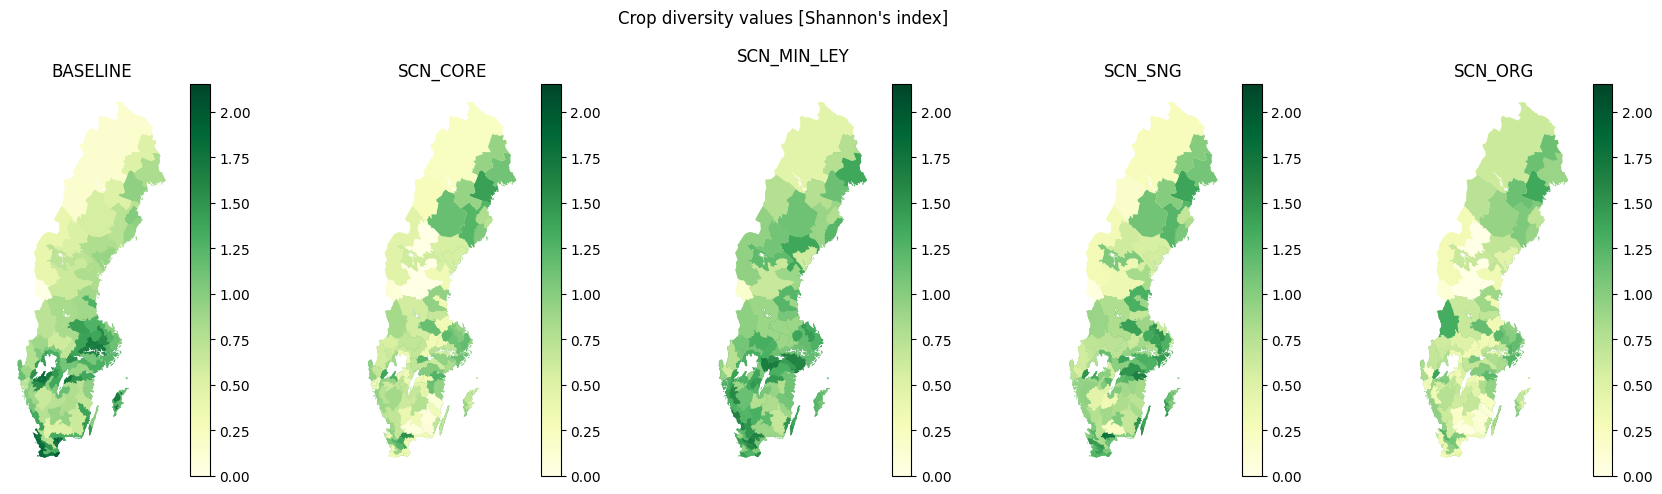

In [45]:
biodiv_data = cm.impact.biodiv.get_crop_div(session).droplevel("year")

fig, axs = plt.subplots(1, len(session.scenarios()), figsize=(18, 5))
vmax=biodiv_data.max().max()

for scn, ax in zip(list(session.scenarios().keys()), axs):
    ax.set_axis_off()
    ax.set_title(scn)
    plot.map_from_series(biodiv_data.loc[(scn),:], cmap="YlGn", ax=ax, vmin=0, vmax=vmax)#, legend_kwds={"label": "Biodiversity index"})

fig.suptitle("Crop diversity values [Shannon's index]")
fig.tight_layout()

## Share of organic land-use

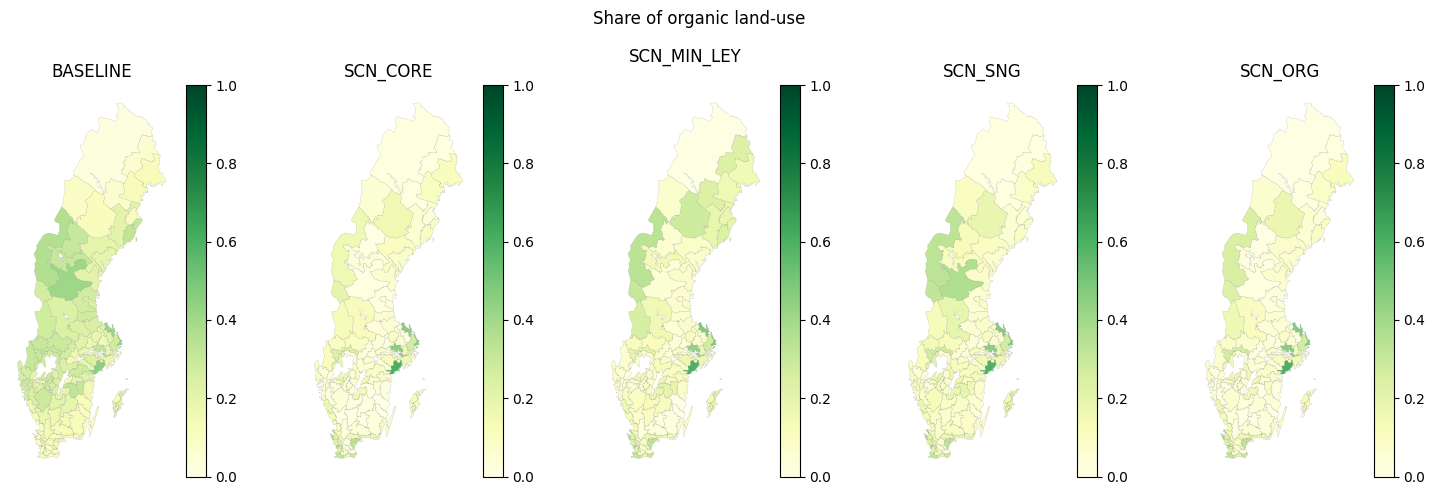

In [46]:
total_prod = session.get_attr("c", "area", ["region"]).droplevel("year")
organic_prod = session.get_attr("c", "area", ["prod_system", "region"]).droplevel("year").loc[:, ("organic", )]
organic_share = (organic_prod / total_prod).replace({ np.inf: 0, -np.inf: 0, np.nan: 0 })

scenarios = [s for s in session.scenarios()]
n_scn = len(scenarios)
fig, axs = plt.subplots(1, len(scenarios), figsize=(n_scn*3, 5))

for scn, ax in zip(scenarios, axs):
    plot.map_from_series(
        organic_share.loc[scn],
        ax=ax,
        vmin=0,
        vmax=1,
        edgecolor="grey",
        cmap="YlGn"
    )
    ax.set_title(scn)
    ax.set_axis_off()

fig.suptitle("Share of organic land-use")
fig.tight_layout()